## Library

In [1865]:
import pandas as pd
import zipfile
%matplotlib inline
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
import seaborn as sns
from pandas.plotting import scatter_matrix
import math
import os
import numpy as np

from sklearn.compose import make_column_selector, make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.feature_selection import SelectFromModel



import matplotlib.font_manager	
plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


## Read In Data

* Train and Test 

In [1866]:
zip_file_path = "30_Training Dataset_V2.zip"
target_csv_file = "training_data.csv"

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    if target_csv_file in zip_ref.namelist():
        zip_ref.extract(target_csv_file, path="temp_folder")
        csv_path = f"temp_folder/{target_csv_file}"
        train = pd.read_csv(csv_path)

zip_file_path = "30_Public Dataset_Public Sumission Template_v2.zip"
target_csv_file = "public_dataset.csv"

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    if target_csv_file in zip_ref.namelist():
        zip_ref.extract(target_csv_file, path="temp_folder")
        csv_path = f"temp_folder/{target_csv_file}"
        test = pd.read_csv(csv_path)

* Data from web scraping

In [1867]:
dtype_dict = {
    3: str,   # Column 3
    5: str,
    6: str,
    7: str,   
    14:str,  
    15:str,
    16:str,
    17:str,
    18: str,
    21: str,
    22: str,
    24: str,
    25: str,
    28: str,
    29:str,
    30:str,
    32:str
}

dirs = [d for d in os.listdir() if d[:4] == 'real']

dfs = []

for d in dirs:
    print(d)
    for letter in 'abcdefghijklmnopqrstuvwxyz':
        file_name = f"{letter}_lvr_land_a.csv"
        if file_name in os.listdir(os.path.join(d)):
            df = pd.read_csv(os.path.join(d, file_name), index_col=False, dtype=dtype_dict)
            df['Q'] = d[-1] # Add the 'Q' column with the last lnumber of the file name, which represent seasons
            df['region'] = letter  # Add the 'region' column with the letter value, which represent regions
            dfs.append(df.iloc[1:])
    
df = pd.concat(dfs, sort=True)

real_estate1071
real_estate1072
real_estate1073
real_estate1074
real_estate1081
real_estate1082
real_estate1083
real_estate1084
real_estate1091
real_estate1092
real_estate1093
real_estate1094
real_estate1101
real_estate1102
real_estate1103
real_estate1104
real_estate1111
real_estate1112
real_estate1113
real_estate1114
real_estate1121
real_estate1122


In [1868]:
region_mapping = {
    'A': '台北市',
    'K': '苗栗縣',
    'U': '花蓮縣',
    'B': '台中市',
    'L': '台中縣',
    'V': '台東縣',
    'C': '基隆市',
    'M': '南投縣',
    'X': '澎湖縣',
    'D': '台南市',
    'N': '彰化縣',
    'E': '高雄市',
    'P': '雲林縣',
    'W': '金門縣',
    'F': '新北市',
    'Q': '嘉義縣',
    'Z': '連江縣',
    'G': '宜蘭縣',
    'R': '台南縣',
    'I': '嘉義市',
    'H': '桃園市',
    'S': '高雄縣',
    'O': '新竹市',
    'J': '新竹縣',
    'T': '屏東縣'
}


區域 = pd.DataFrame(list(region_mapping.items()), columns=['身分證字號', '地區'])

區域['身分證字號'] = 區域['身分證字號'].str.lower()

df = df.merge(區域, left_on='region', right_on='身分證字號', how='left')

# 平方公尺換成坪
df['單價元平方公尺'] = df['單價元平方公尺'].astype(float)
df['單價元坪'] = df['單價元平方公尺'] * 3.30579

# 建物型態
df['建物型態2'] = df['建物型態'].str.split('(').str[0]

# 刪除有備註之交易（多為親友交易、價格不正常之交易）
df = df[df['備註'].isnull()]

# 將index改成年月日
df.index = pd.to_datetime((df['交易年月日'].str[:-4].astype(int) + 1911).astype(str) + df['交易年月日'].str[-4:] ,errors='coerce')

#Drop some useless columns
columns_to_drop = ["備註", '建物型態', "建物現況格局-廳", "建物現況格局-房", "建物現況格局-衛", "建物現況格局-隔間", "有無管理組織", "移轉編號", "編號", "車位總價元", "車位類別", "都市土地使用分區", "非都市土地使用分區", "非都市土地使用編定", "region", "身分證字號"]
df = df.drop(columns=columns_to_drop)

# Columns to fill with "unknown"
columns_to_fill_unknown = ["主要建材", "主要用途", "移轉層次", "總樓層數", "電梯"]
df[columns_to_fill_unknown] = df[columns_to_fill_unknown].fillna("unknown")

# 新增交易年份
df['交易year'] = df['交易年月日'].str[:-4].astype(int) + 1911

# Calculate the year of construction and add it as '建築year'
df = df.dropna(subset=["建築完成年月"])
df['建築完成年月'] = df['建築完成年月'].str[:-4]
df['建築完成年月']= pd.to_numeric(df['建築完成年月'], errors='coerce')
df['建築year'] = df['建築完成年月'] + 1911

# Calculate the age of the building and add it as 'age'
df["age"] = df['交易year'] - df['建築year']

# Calculate the age of the building and add it as 'age'
df["age"] = df['交易year'] - df['建築year']

#Drop more useless columns
df = df.drop(columns='建築完成年月')
df = df.drop(columns='車位移轉總面積平方公尺')

# Filter observations where "age" >= 0
df = df[df['age'] >= 0]

#Drop Na, because it just a small amount of observations
df.dropna(inplace=True)

#Columns that should ne numeric
columns_to_convert_cumeric = ["主建物面積", "單價元平方公尺", "土地移轉總面積平方公尺", "建物移轉總面積平方公尺", "總價元", "附屬建物面積", "陽台面積", "單價元坪"]
df[columns_to_convert_cumeric] = df[columns_to_convert_cumeric].apply(pd.to_numeric, errors='coerce')

#縣市_鄉鎮市區
df['縣市_鄉鎮市區'] = df['地區'] + '_' + df['鄉鎮市區'] 

#reset index
df.drop(columns=["交易年月日"], inplace=True)
df.reset_index(inplace=True)

* bus station

In [1869]:
bus_station_train = pd.read_csv("external_data_2/bus_station_train.csv")
bus_station_test= pd.read_csv("external_data_2/bus_station_test.csv")

In [1870]:
train = pd.merge(train, bus_station_train, on='ID', how='left')
test = pd.merge(test, bus_station_test, on='ID', how='left')

* Bad Facilities and Landmarks

In [1871]:
bad_facilities_landmarks_train = pd.read_csv("external_data_2/bad_facilities_landmarks_train.csv")
bad_facilities_landmarks_test = pd.read_csv("external_data_2/bad_facilities_landmarks_test.csv")

In [1872]:
train = pd.merge(train, bad_facilities_landmarks_train, on='ID', how='left')
test = pd.merge(test, bad_facilities_landmarks_test, on='ID', how='left')

In [1873]:
#columns_to_drop = ["高度壞地標數", "中度壞地標數", "輕度壞地標數"]
#train = train.drop(columns=columns_to_drop)
#test = test.drop(columns=columns_to_drop)

* Good Facilities and Landmarks

In [1874]:
good_facilities_landmarks_train = pd.read_csv("external_data_2/good_facilities_landmarks_train.csv")
good_facilities_landmarks_test = pd.read_csv("external_data_2/good_facilities_landmarks_test.csv")

In [1875]:
train = pd.merge(train, good_facilities_landmarks_train, on='ID', how='left')
test = pd.merge(test, good_facilities_landmarks_test, on='ID', how='left')

* Finance

In [1876]:
finance_train = pd.read_csv("external_data_2/train_finance.csv")
finance_test = pd.read_csv("external_data_2/test_finance.csv")

In [1877]:
train = pd.merge(train, finance_train, on='ID', how='left')
test = pd.merge(test, finance_test, on='ID', how='left')

* elementry

In [1878]:
elementry_train = pd.read_csv("external_data_2/train_elementary.csv")
elementry_test= pd.read_csv("external_data_2/test_elementary.csv")

In [1879]:
train = pd.merge(train, elementry_train, on='ID', how='left')
test = pd.merge(test, elementry_test, on='ID', how='left')

---

In [1880]:
train.head(1)

,ID,縣市,鄉鎮市區,路名,土地面積,使用分區,移轉層次,總樓層數,主要用途,主要建材,建物型態,屋齡,建物面積,車位面積,車位個數,橫坐標,縱坐標,備註,主建物面積,陽台面積,附屬建物面積,單價,站點數,高度壞地標數,中度壞地標數,輕度壞地標數,bad_score,公園圖書館,金融機構數,學生教職員總人數,權重
0,TR-1,台北市,大安區,敦化南路二段,-0.256716,None,11,11,住家用,鋼筋混凝土造,住宅大樓(11層含以上有電梯),32.583333,-0.174154,-0.819326,0.0,305266,2768378,NaN,0.393926,0.1837,-0.438452,4.627714,546.0,NaN,NaN,NaN,NaN,NaN,35.0,40566.0,11.4


In [1881]:
test.head(3)

,ID,縣市,鄉鎮市區,路名,土地面積,使用分區,移轉層次,總樓層數,主要用途,主要建材,建物型態,屋齡,建物面積,車位面積,車位個數,橫坐標,縱坐標,備註,主建物面積,陽台面積,附屬建物面積,站點數,高度壞地標數,中度壞地標數,輕度壞地標數,bad_score,公園圖書館,金融機構數,學生教職員總人數,權重
0,PU-1,新北市,樹林區,大有路,2.039378,None,3,7,住家用,鋼筋混凝土造,華廈(10層含以下有電梯),13.916667,0.472202,0.146176,1.0,288745,2760266,NaN,0.849664,0.146161,-0.438452,340.0,NaN,NaN,NaN,NaN,1.0,5.0,11098.0,3.80
1,PU-2,新北市,三重區,力行路一段,-0.077786,None,5,5,住家用,鋼筋混凝土造,公寓(5樓含以下無電梯),40.833333,-0.546455,-0.819326,0.0,298751,2773492,NaN,-0.004102,0.064257,-0.438452,200.0,0.0,0.0,1.0,1.1,6.0,15.0,29958.0,7.85
2,PU-3,新北市,板橋區,民生路三段,-0.555766,None,2,20,集合住宅,鋼筋混凝土造,住宅大樓(11層含以上有電梯),1.333333,0.124032,-0.167419,1.0,297000,2769106,NaN,-0.285862,-0.775260,1.323042,274.0,NaN,NaN,NaN,NaN,NaN,25.0,29625.0,7.40


---

In [1882]:
train_raw = train.copy()#Save the raw data that may use later

train_id_column = train['ID']  # Store the "ID" column in a separate variable
train.set_index("ID", inplace=True)

X_train = train.drop(columns=['單價'])
y_train = train['單價'].copy()

## Baseline Model

In [1883]:
#num_cols = X_train.select_dtypes(include='number')
#cat_cols = X_train.select_dtypes(include='object').drop(columns=['備註'])#暫時先不考慮備註

In [1884]:
#cat_pipeline = Pipeline([
    #("onehot", OneHotEncoder(handle_unknown="ignore"))])

In [1885]:
#preprocessing  = ColumnTransformer(
    #transformers=[
        #("categorical", cat_pipeline, cat_cols.columns),],
    #remainder= "passthrough")
#preprocessing

In [1886]:
#full_pipeline_rf1 = Pipeline(
    #[("preprocessing", preprocessing), ("rf1", RandomForestRegressor(random_state=42))])

#full_pipeline_rf1.fit(X_train.drop(columns=['備註']), y_train)

In [1887]:
def NMAPE(y_true, y_pred): 
    return 1 - np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#make scorer from custome function
nmape_scorer = make_scorer(NMAPE)
#cross_val_score(full_pipeline_rf1, X_train.drop(columns=['備註']), y_train.drop(columns=['備註']), scoring=nmape_scorer, cv=3)

In [1888]:
#feature_importance = full_pipeline_rf1.named_steps['rf1'].feature_importances_
#importance = sorted(zip(feature_importance, full_pipeline_rf1["preprocessing"].get_feature_names_out()),reverse= True)
#pd.DataFrame(importance, columns=['importance', 'variables']).head(20)

In [1889]:
test_id_column = test['ID']



In [1890]:
#base_line_pred = full_pipeline_rf1.predict(test)
#base_line_pred = pd.DataFrame({'ID': test.index, 'predicted_price': base_line_pred})

In [1891]:
#base_line_pred.to_csv("prediction/baseline_predictions.csv", index=False)

## Feature Engineering

先解決名字重複的問題

* 縣市_鄉鎮市區

在不同縣市有相同鄉鎮市區，例如台北市與基隆都有中正區

合併縣市與鄉鎮市區

In [1892]:
train['縣市_鄉鎮市區'] = train['縣市'] + '_' + train['鄉鎮市區'] 

train.head(1)

,縣市,鄉鎮市區,路名,土地面積,使用分區,移轉層次,總樓層數,主要用途,主要建材,建物型態,屋齡,建物面積,車位面積,車位個數,橫坐標,縱坐標,備註,主建物面積,陽台面積,附屬建物面積,單價,站點數,高度壞地標數,中度壞地標數,輕度壞地標數,bad_score,公園圖書館,金融機構數,學生教職員總人數,權重,縣市_鄉鎮市區
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TR-1,台北市,大安區,敦化南路二段,-0.256716,None,11,11,住家用,鋼筋混凝土造,住宅大樓(11層含以上有電梯),32.583333,-0.174154,-0.819326,0.0,305266,2768378,NaN,0.393926,0.1837,-0.438452,4.627714,546.0,NaN,NaN,NaN,NaN,NaN,35.0,40566.0,11.4,台北市_大安區


* 縣市_鄉鎮市區_路名

在不同鄉鎮市區有相同的路名:

In [1893]:
road_town_counts = train.groupby(['路名', '鄉鎮市區']).size().reset_index(name='count')

road_town_counts.groupby(['路名']).size().reset_index(name='count').sort_values("count", ascending=False).query('count > 1').head(1)

,路名,count
132,中正路,22


合併鄉鎮市區與路名

In [1894]:
train['縣市_鄉鎮市區_路名'] = train['縣市'] + '_' + train['鄉鎮市區'] + '_' + train['路名']

train.head(1)

,縣市,鄉鎮市區,路名,土地面積,使用分區,移轉層次,總樓層數,主要用途,主要建材,建物型態,屋齡,建物面積,車位面積,車位個數,橫坐標,縱坐標,備註,主建物面積,陽台面積,附屬建物面積,單價,站點數,高度壞地標數,中度壞地標數,輕度壞地標數,bad_score,公園圖書館,金融機構數,學生教職員總人數,權重,縣市_鄉鎮市區,縣市_鄉鎮市區_路名
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TR-1,台北市,大安區,敦化南路二段,-0.256716,None,11,11,住家用,鋼筋混凝土造,住宅大樓(11層含以上有電梯),32.583333,-0.174154,-0.819326,0.0,305266,2768378,NaN,0.393926,0.1837,-0.438452,4.627714,546.0,NaN,NaN,NaN,NaN,NaN,35.0,40566.0,11.4,台北市_大安區,台北市_大安區_敦化南路二段


## Category Features

* 鄉鎮市區

先來看一下分布

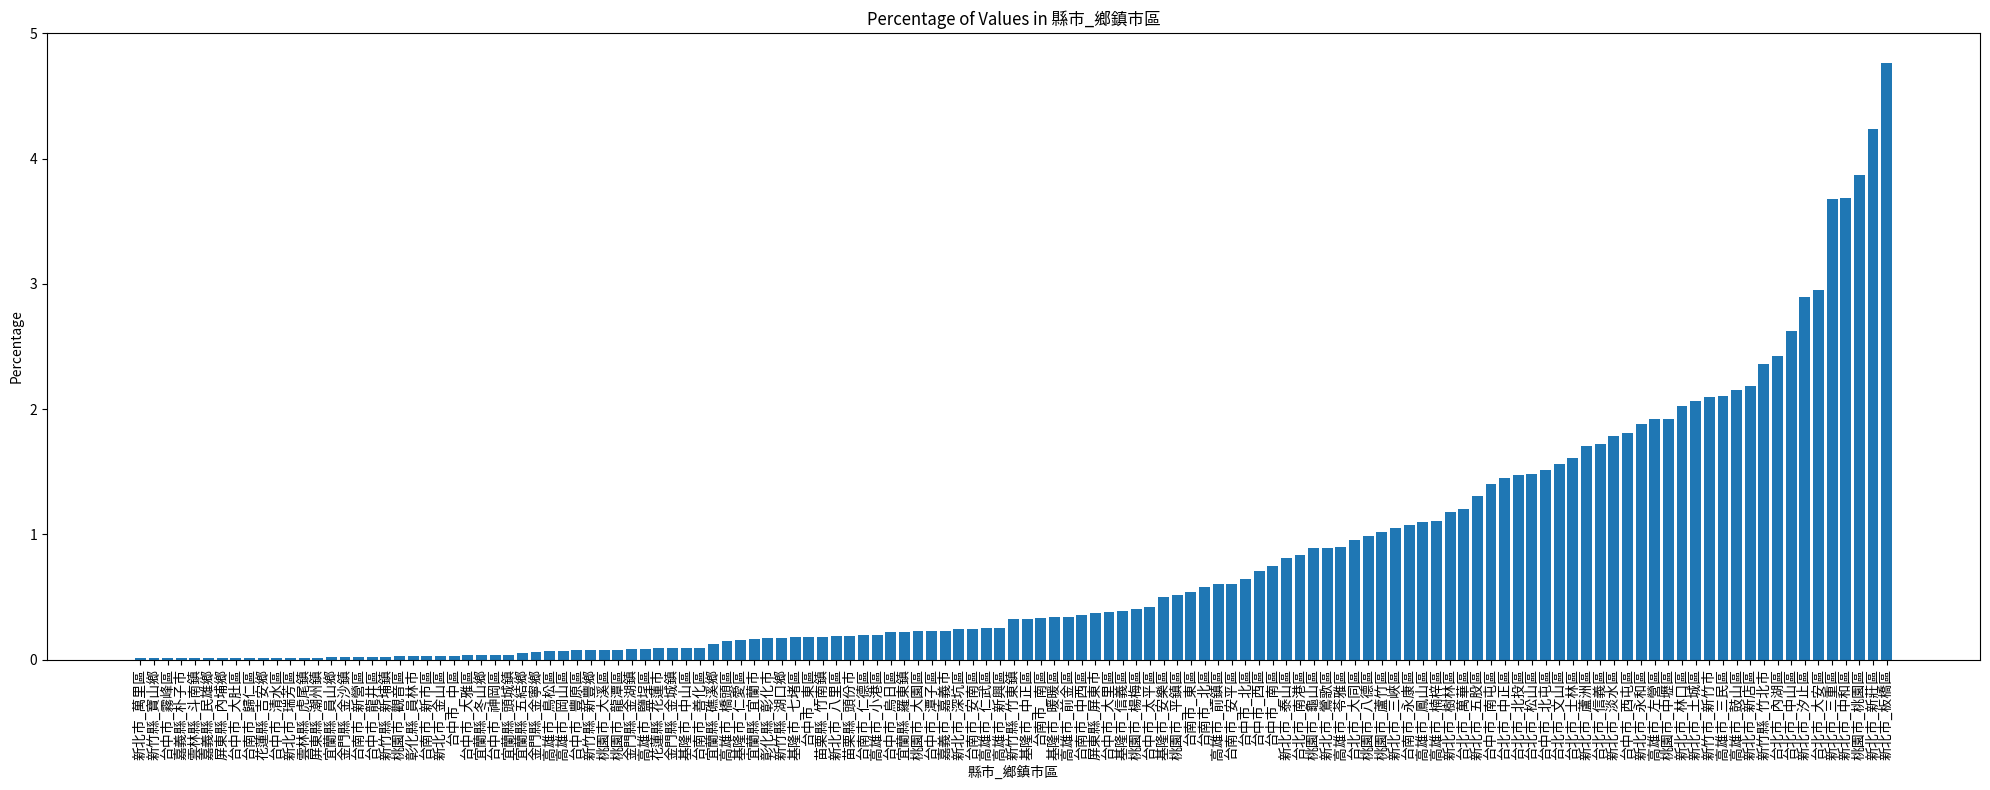

In [1895]:
column_name = '縣市_鄉鎮市區'

# Calculate the value counts and percentages
value_counts = train[column_name].value_counts()
percentages = (value_counts / len(train)) * 100

# Create a DataFrame to display the results
value_percentage_df = pd.DataFrame({'Value': value_counts.index, 'Count': value_counts.values, 'Percentage': percentages.values})

# Sort the DataFrame by percentage in descending order
value_percentage_df = value_percentage_df.sort_values(by='Percentage', ascending=True)

plt.figure(figsize=(20, 8))  # Adjust the figure size if needed
plt.bar(value_percentage_df['Value'], value_percentage_df['Percentage'])
plt.xlabel(column_name)
plt.ylabel('Percentage')
plt.title(f'Percentage of Values in {column_name}')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Ensure labels fit within the figure boundaries

# Show the plot
plt.show()

由於鄉鎮市區中不同的值太多且有一些值太稀少，我打算合併成group。先看一下不同區域"單價"的mean和median

In [1896]:
def plot_mean_and_median(df, column_name, target_column='單價'):
    # Group by the specified column and calculate mean and median
    grouped_data = df.groupby(column_name)[target_column].agg(['mean', 'median']).reset_index()

    # Sort the dataframes by mean and median values
    sorted_mean_data = grouped_data.sort_values(by='mean', ascending=False)
    sorted_median_data = grouped_data.sort_values(by='median', ascending=False)

    # Create a plot for the sorted mean
    plt.figure(figsize=(20, 8))
    plt.bar(sorted_mean_data[column_name], sorted_mean_data['mean'])
    plt.xlabel(column_name)
    plt.ylabel(f'Mean {target_column}')
    plt.title(f'Sorted Mean {target_column} by {column_name}')
    plt.xticks(rotation=90)  # Adjust rotation as needed
    plt.tight_layout()
    plt.show()

    # Create a plot for the sorted median
    plt.figure(figsize=(20, 8))
    plt.bar(sorted_median_data[column_name], sorted_median_data['median'])
    plt.xlabel(column_name)
    plt.ylabel(f'Median {target_column}')
    plt.title(f'Sorted Median {target_column} by {column_name}')
    plt.xticks(rotation=90)  # Adjust rotation as needed
    plt.tight_layout()
    plt.show()

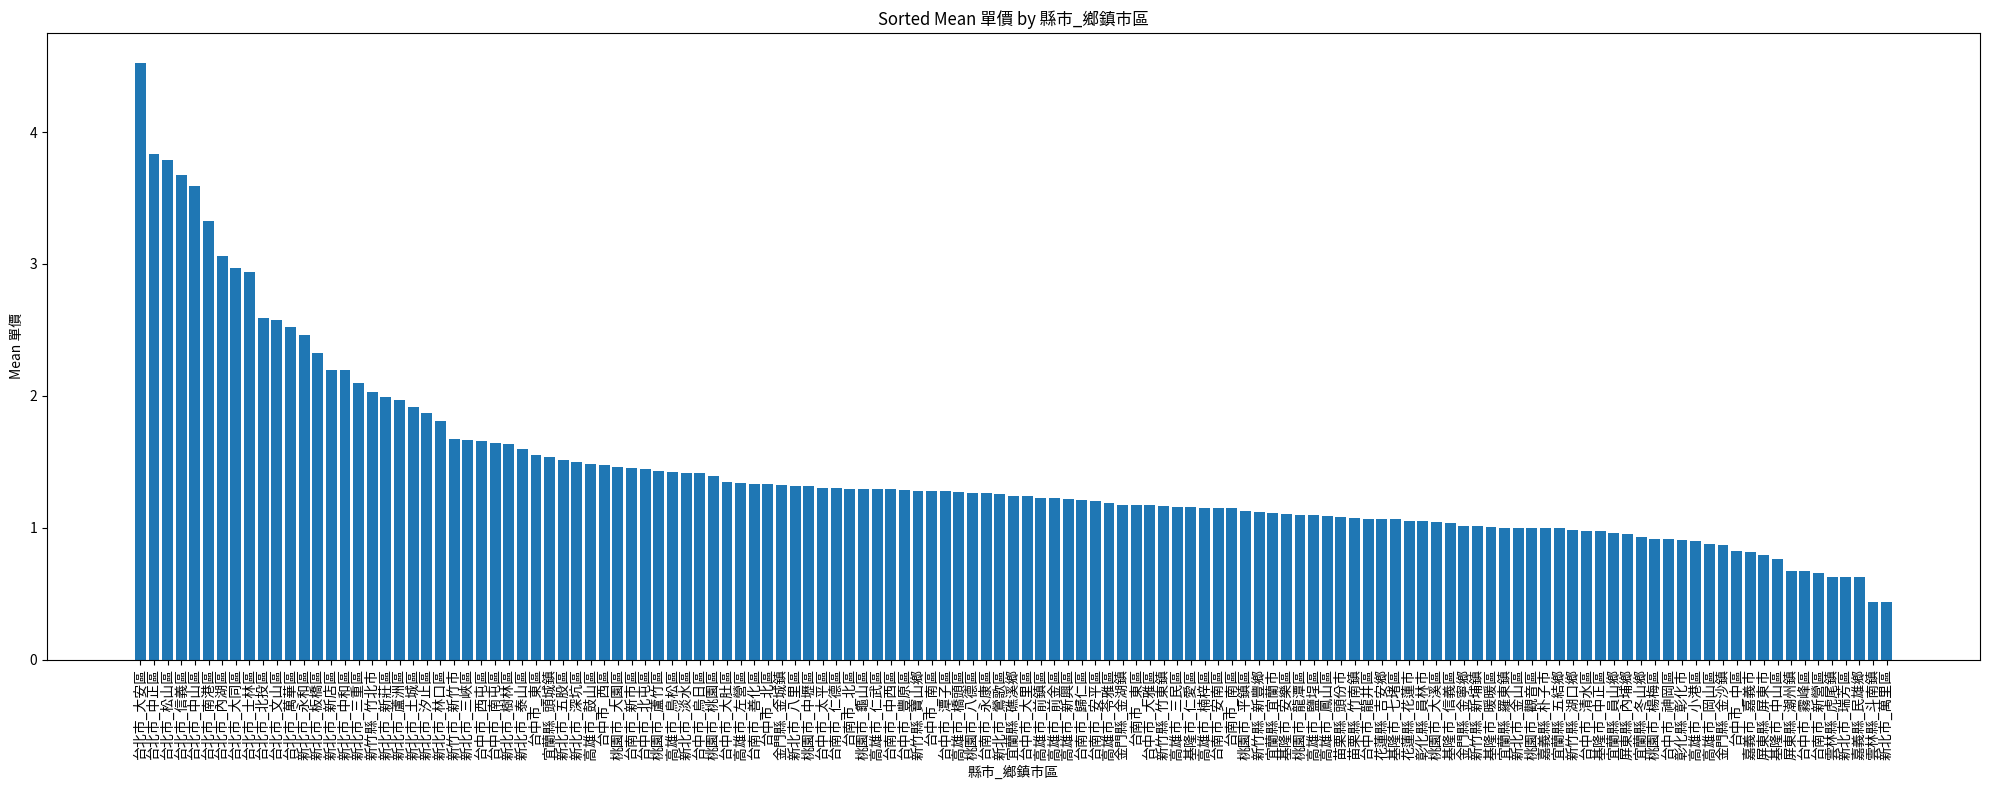

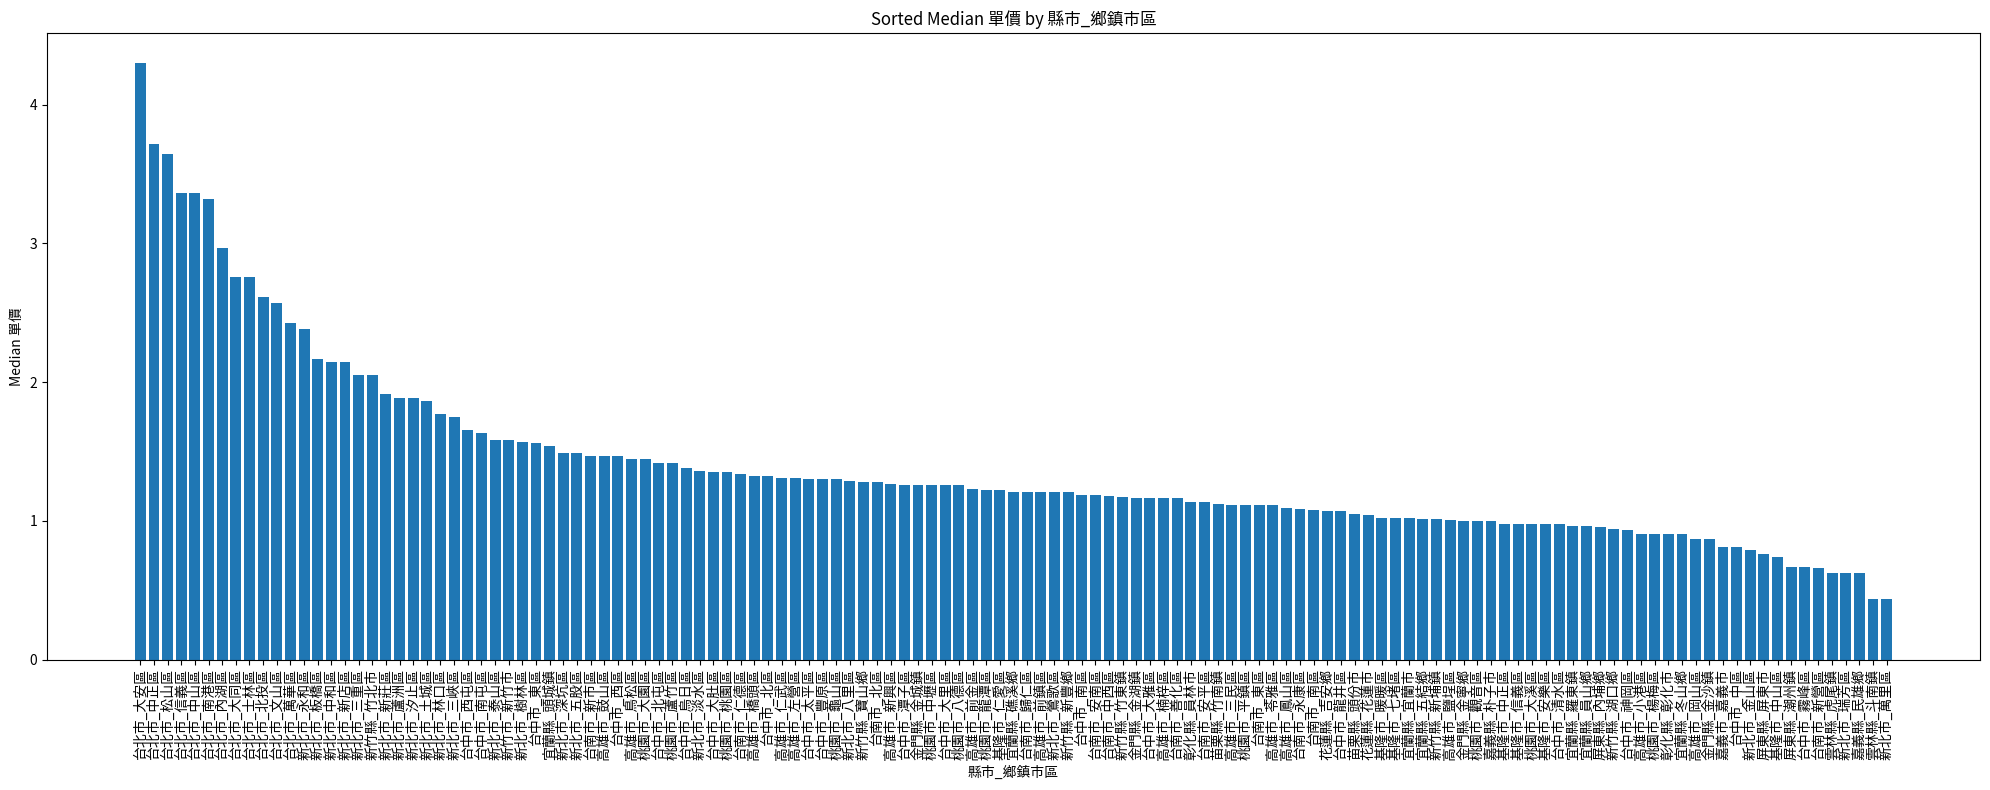

In [1897]:
plot_mean_and_median(train, '縣市_鄉鎮市區')

mean跟median差異不大，且分布符合常理(貴的地方都在台北，便宜的都是鄉下)，因此我打算根據上表、我對房價的了解以及網路上找的各鄉鎮市區單價區間分組

In [1898]:
# Group the DataFrame by '鄉鎮市區' and calculate the desired statistics
grouped_data = df.groupby('縣市_鄉鎮市區')[['單價元坪', '總價元']].agg(['mean', 'median', 'max', 'min'])

# Reset the index to make the '鄉鎮市區' column a regular column
grouped_data = grouped_data.reset_index()

# Rename the columns for clarity
grouped_data.columns = ['縣市_鄉鎮市區', '單價元坪_mean', '單價元坪_median', '單價元坪_max', '單價元坪_min', '總價元_mean', '總價元_median', '總價元_max', '總價元_min']

In [1899]:
十 = ["台北市_大安區", "台北市_中正區", "台北市_信義區", "台北市_中山區", "台北市_松山區"]
九 = ["台北市_大同區", "台北市_士林區", "台北市_內湖區", "台北市_南港區", "台北市_萬華區", "台北市_文山區", "台北市_北投區"]
八 = ["新北市_永和區", "新北市_板橋區", "新北市_中和區", "新北市_新店區", "新北市_三重區", "新北市_新莊區", "新北市_蘆洲區", "新北市_土城區", "新北市_汐止區", "新北市_坪林區", "新竹縣_竹北市", "新北市_平溪區", "新北市_汐止區"]
七 = ["新北市_泰山區", "新北市_林口區", "新北市_五股區", "新北市_樹林區", "新北市_深坑區", "新北市_三峽區", "苗栗縣_泰安鄉", "台中市_和平區", "台中市_南屯區", "南投縣_仁愛鄉", "台中市_西屯區"]
六 = ["高雄市_前金區", "高雄市_鼓山區", "桃園市_桃園區", "新北市_淡水區", "桃園市_龜山區", "宜蘭縣_頭城鎮", "台中市_北屯區", "新竹市_新竹市", "台中市_烏日區", "台中市_西區", "新北市_鶯歌區", "桃園市_蘆竹區", "高雄市_仁武區", "高雄市_苓雅區", "新北市_八里區", "台中市_神岡區", "高雄市_左營區", "台中市_東區", "桃園市_大園區", "台中市_豐原區", "金門縣_金城鎮", "台中市_大雅區", "台中市_北區", "台中市_后里區", "新竹縣_新埔鎮", "台中市_南區", "台中市_太平區", "桃園市_中壢區", "宜蘭縣_礁溪鄉", "台中市_沙鹿區", "台中市_大里區", "金門縣_金湖鎮", "台中市_潭子區"]
五 = grouped_data.query("單價元坪_median <= 200000 & 單價元坪_median > 175000")["縣市_鄉鎮市區"].tolist()
四 = grouped_data.query("單價元坪_median <= 175000 & 單價元坪_median > 150000")["縣市_鄉鎮市區"].tolist()
三 = grouped_data.query("單價元坪_median <= 150000 & 單價元坪_median > 100000")["縣市_鄉鎮市區"].tolist()
二 = grouped_data.query("單價元坪_median <= 100000 & 單價元坪_median > 50000")["縣市_鄉鎮市區"].tolist()
一 = grouped_data.query("單價元坪_median <= 50000")["縣市_鄉鎮市區"].tolist()

In [1900]:
for index, row in train.iterrows():
    if row["縣市_鄉鎮市區"] in 十:
        train.at[index, "縣市_鄉鎮市區"] = "10"
    elif row["縣市_鄉鎮市區"] in 九:
        train.at[index, "縣市_鄉鎮市區"] = "9"
    elif row["縣市_鄉鎮市區"] in 八:
        train.at[index, "縣市_鄉鎮市區"] = "8"
    elif row["縣市_鄉鎮市區"] in 七:
        train.at[index, "縣市_鄉鎮市區"] = "7"
    elif row["縣市_鄉鎮市區"] in 六:
        train.at[index, "縣市_鄉鎮市區"] = "6"
    elif row["縣市_鄉鎮市區"] in 五:
        train.at[index, "縣市_鄉鎮市區"] = "5"
    elif row["縣市_鄉鎮市區"] in 四:
        train.at[index, "縣市_鄉鎮市區"] = "4"
    elif row["縣市_鄉鎮市區"] in 三:
        train.at[index, "縣市_鄉鎮市區"] = "3"
    elif row["縣市_鄉鎮市區"] in 二:
        train.at[index, "縣市_鄉鎮市區"] = "2"
    elif row["縣市_鄉鎮市區"] in 一:
        train.at[index, "縣市_鄉鎮市區"] = "1"

**此feature應該做ordinal encoding**

* 主要用途

In [1901]:
#plot_mean_and_median(train, '主要用途')

**此feature可能要做1hot encoding**

* 主要建材

In [1902]:
#plot_mean_and_median(train, "主要建材")

In [1903]:
material_mapping = {
    "鋼骨造": "鋼骨造",
    "其他": "其他",
    "加強磚造": "其他",
    "磚造": "其他",
    "鋼筋混凝土造": "其他",
    "鋼筋混凝土加強磚造": "鋼筋混凝土加強磚造"
}
train['主要建材_分組'] = train['主要建材'].map(material_mapping)

In [1904]:
#plot_mean_and_median(train, "主要建材_分組")

**此feature可能做ordinal encoding**

## Feature Generation

### 地理位置衍生

* 先將橫坐標、縱坐標轉換Longitude、Latitude(將TWD97二度分帶座標值轉換為經緯度)

In [1905]:
# function來源: https://tylerastro.medium.com/twd97-to-longitude-latitude-dde820d83405
def twd97_to_lonlat(x=174458.0,y=2525824.0):
    """
    Parameters
    ----------
    x : float
        TWD97 coord system. The default is 174458.0.
    y : float
        TWD97 coord system. The default is 2525824.0.
    Returns
    -------
    list
        [longitude, latitude]
    """
    
    a = 6378137
    b = 6356752.314245
    long_0 = 121 * math.pi / 180.0
    k0 = 0.9999
    dx = 250000
    dy = 0
    
    e = math.pow((1-math.pow(b, 2)/math.pow(a,2)), 0.5)
    
    x -= dx
    y -= dy
    
    M = y / k0
    
    mu = M / ( a*(1-math.pow(e, 2)/4 - 3*math.pow(e,4)/64 - 5 * math.pow(e, 6)/256))
    e1 = (1.0 - pow((1   - pow(e, 2)), 0.5)) / (1.0 +math.pow((1.0 -math.pow(e,2)), 0.5))
    
    j1 = 3*e1/2-27*math.pow(e1,3)/32
    j2 = 21 * math.pow(e1,2)/16 - 55 * math.pow(e1, 4)/32
    j3 = 151 * math.pow(e1, 3)/96
    j4 = 1097 * math.pow(e1, 4)/512
    
    fp = mu + j1 * math.sin(2*mu) + j2 * math.sin(4* mu) + j3 * math.sin(6*mu) + j4 * math.sin(8* mu)
    
    e2 = math.pow((e*a/b),2)
    c1 = math.pow(e2*math.cos(fp),2)
    t1 = math.pow(math.tan(fp),2)
    r1 = a * (1-math.pow(e,2)) / math.pow( (1-math.pow(e,2)* math.pow(math.sin(fp),2)), (3/2))
    n1 = a / math.pow((1-math.pow(e,2)*math.pow(math.sin(fp),2)),0.5)
    d = x / (n1*k0)
    
    q1 = n1* math.tan(fp) / r1
    q2 = math.pow(d,2)/2
    q3 = ( 5 + 3 * t1 + 10 * c1 - 4 * math.pow(c1,2) - 9 * e2 ) * math.pow(d,4)/24
    q4 = (61 + 90 * t1 + 298 * c1 + 45 * math.pow(t1,2) - 3 * math.pow(c1,2) - 252 * e2) * math.pow(d,6)/720
    lat = fp - q1 * (q2 - q3 + q4)
    
    
    q5 = d
    q6 = (1+2*t1+c1) * math.pow(d,3) / 6
    q7 = (5 - 2 * c1 + 28 * t1 - 3 * math.pow(c1,2) + 8 * e2 + 24 * math.pow(t1,2)) * math.pow(d,5) / 120
    lon = long_0 + (q5 - q6 + q7) / math.cos(fp)
    
    lat = (lat*180) / math.pi
    lon = (lon*180) / math.pi
    return [lon, lat]

In [1906]:
train['long'], train['lat'] = zip(*train.apply(lambda row: twd97_to_lonlat(row['橫坐標'], row['縱坐標']), axis=1))

In [1907]:
train.head(3)

,縣市,鄉鎮市區,路名,土地面積,使用分區,移轉層次,總樓層數,主要用途,主要建材,建物型態,屋齡,建物面積,車位面積,車位個數,橫坐標,縱坐標,備註,主建物面積,陽台面積,附屬建物面積,單價,站點數,高度壞地標數,中度壞地標數,輕度壞地標數,bad_score,公園圖書館,金融機構數,學生教職員總人數,權重,縣市_鄉鎮市區,縣市_鄉鎮市區_路名,主要建材_分組,long,lat
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TR-1,台北市,大安區,敦化南路二段,-0.256716,None,11,11,住家用,鋼筋混凝土造,住宅大樓(11層含以上有電梯),32.583333,-0.174154,-0.819326,0.0,305266,2768378,NaN,0.393926,0.183700,-0.438452,4.627714,546.0,NaN,NaN,NaN,NaN,NaN,35.0,40566.0,11.40,10,台北市_大安區_敦化南路二段,其他,121.547608,25.022469
TR-2,台北市,萬華區,水源路,0.100134,None,7,12,住家用,鋼筋混凝土造,住宅大樓(11層含以上有電梯),24.166667,0.314204,-0.819326,0.0,300677,2767990,NaN,-0.316131,0.608577,-0.438452,1.887258,244.0,NaN,NaN,NaN,NaN,NaN,4.0,20359.0,6.35,9,台北市_萬華區_水源路,其他,121.502124,25.019127
TR-3,高雄市,鳳山區,北忠街,0.181921,None,10,15,集合住宅,其他,住宅大樓(11層含以上有電梯),6.166667,0.423366,0.161624,1.0,184815,2504666,NaN,-0.098871,-0.360620,1.525881,1.489072,74.0,0.0,0.0,1.0,1.1,1.0,2.0,13359.0,4.50,5,高雄市_鳳山區_北忠街,其他,120.365799,22.640966


In [1908]:
import folium
from folium.plugins import FastMarkerCluster, Fullscreen, MiniMap, HeatMap, HeatMapWithTime, LocateControl

In [1909]:

lats = list((train)['lat'].values)
longs = list((train)['long'].values)
locations = list(zip(lats, longs))


map1 = folium.Map(location=[24, 121.5], zoom_start=8.0)


FastMarkerCluster(data=locations).add_to(map1)

#map1

**training set沒有台東、南投、澎湖、苗栗、雲林的資料**

* 北中南東外島

In [1910]:
city_to_region = {
    '北部': ['台北市', '新北市', '基隆市', '新竹市', '桃園市', '新竹縣'],
    '中部': ['台中市', '苗栗縣', '彰化縣', '南投縣', '雲林縣'],
    '南部': ['高雄市', '台南市', '嘉義市', '嘉義縣', '屏東縣', '澎湖縣'],
    '東部': ['花蓮縣', '臺東縣', '宜蘭縣'],
    '外島': ['澎湖縣', '金門縣', '連江縣']
}

# Create a function to map cities to regions
def map_city_to_region(city):
    for region, cities in city_to_region.items():
        if city in cities:
            return region
    return 'Unknown'  # Return 'Unknown' if city doesn't match any region

# Apply the mapping function to create the 'Region' column
train['region'] = train['縣市'].apply(map_city_to_region)



In [1911]:
column_name = 'region'
target_column = '單價'

# Group by 'region' and calculate mean and median
grouped_data = train.groupby(column_name)[target_column].agg(['mean', 'median']).reset_index()

# Sort the dataframes by mean and median values
sorted_mean_data = grouped_data.sort_values(by='mean', ascending=False)
sorted_median_data = grouped_data.sort_values(by='median', ascending=False)


#plt.figure(figsize=(12, 6))
#plt.bar(sorted_mean_data[column_name], sorted_mean_data['mean'])
#plt.xlabel(column_name)
#plt.ylabel('Mean ' + target_column)
#plt.title(f'Sorted Mean {target_column} by {column_name}')
#plt.xticks(rotation=90)
#plt.tight_layout()
#plt.show()


#plt.figure(figsize=(12, 6))
#plt.bar(sorted_median_data[column_name], sorted_median_data['median'])
#plt.xlabel(column_name)
#plt.ylabel('Median ' + target_column)
#plt.title(f'Sorted Median {target_column} by {column_name}')
#plt.xticks(rotation=90)
#plt.tight_layout()
#plt.show()

**此feature應該做ordinal encoding**

* 縣市層級(首都、直轄市...)

In [1912]:

conditions = [
    train["縣市"] == "台北市",
    train["縣市"].isin(["新北市", "桃園市", "臺中市", "臺南市", "高雄市"])
]

values = ["capital", "municipality"]

# Use numpy.select to create the new "直轄市" column
train["直轄市"] = np.select(conditions, values, default="others")


column_name = '直轄市'
target_column = '單價'

grouped_data = train.groupby(column_name)[target_column].agg(['mean', 'median']).reset_index()

sorted_mean_data = grouped_data.sort_values(by='mean', ascending=False)
sorted_median_data = grouped_data.sort_values(by='median', ascending=False)

#plt.figure(figsize=(12, 6))
#plt.bar(sorted_mean_data[column_name], sorted_mean_data['mean'])
#plt.xlabel(column_name)
#plt.ylabel('Mean ' + target_column)
#plt.title(f'Sorted Mean {target_column} by {column_name}')
#plt.xticks(rotation=0)  
#plt.tight_layout()
#plt.show()

#plt.figure(figsize=(12, 6))
#plt.bar(sorted_median_data[column_name], sorted_median_data['median'])
#plt.xlabel(column_name)
#plt.ylabel('Median ' + target_column)
#plt.title(f'Sorted Median {target_column} by {column_name}')
#plt.xticks(rotation=0)  
#plt.tight_layout()
#plt.show()



**此feature應該做ordinal encoding**

* 里

import geopy
from geopy.geocoders import Nominatim
geopy.geocoders.options.default_user_agent = "my-application"
gnom=Nominatim(user_agent="http")
geopy.geocoders.options.default_user_agent = "my-application"
gnom=Nominatim(user_agent="http")
def reverse_geocode(row):
    try:
        location = gnom.reverse(f"{row['lat']}, {row['long']}", exactly_one=True)
        return location.address
    except:
        return "Address not found"  # Return a placeholder if address lookup fails

# Apply the reverse geocoding function to create the 'complete_location' column
train['complete_location'] = train.apply(reverse_geocode, axis=1)

* cluster_simil

在 fit()中使用 KMeans 聚類來識別訓練數據中的主要聚類，然後在transform()中使用 rbf_kernel() 來衡量每個樣本與每個聚類中心的相似程度。 創建一個 ClusterSimilarity 轉換器，將簇數設置為10。然後它使用訓練集中每個地區的緯度和經度調用 fit_transform()，並且可以按某個值加權。 transformer 使用 k-means 來定位集群，然後測量每個地區與所有 10 個集群中心之間的高斯 RBF 相似度。 結果是一個矩陣，每個區一行，每個集群一欄。

可以tune的參數: n_clusters、gamma、sample_weight

In [1913]:
class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters = None, gamma = None, sample_weight = None, random_state = None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.sample_weight = sample_weight
        self.random_state = random_state

    def fit(self, X, y=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=self.sample_weight)
        return self 
    
    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]
    

cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)

In [1914]:
preprocessing_cluster_simil = ColumnTransformer(
    transformers=[
        ("geo", cluster_simil, ["lat", "long"])
    ],
      remainder= "passthrough"                        )  
preprocessing_cluster_simil

test_cluster_simil = train.copy()

test_cluster_simil = preprocessing_cluster_simil.fit_transform(test_cluster_simil)

#Put the new features back to the dataframe
train = pd.DataFrame(
    test_cluster_simil,
    columns=preprocessing_cluster_simil.get_feature_names_out(),
    index=train.index
)

train.rename(columns=lambda x: x.replace('remainder__', ''), inplace=True)
train.head(1)

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


,geo__Cluster 0 similarity,geo__Cluster 1 similarity,geo__Cluster 2 similarity,geo__Cluster 3 similarity,geo__Cluster 4 similarity,geo__Cluster 5 similarity,geo__Cluster 6 similarity,geo__Cluster 7 similarity,geo__Cluster 8 similarity,geo__Cluster 9 similarity,縣市,鄉鎮市區,路名,土地面積,使用分區,移轉層次,總樓層數,主要用途,主要建材,建物型態,屋齡,建物面積,車位面積,車位個數,橫坐標,縱坐標,備註,主建物面積,陽台面積,附屬建物面積,單價,站點數,高度壞地標數,中度壞地標數,輕度壞地標數,bad_score,公園圖書館,金融機構數,學生教職員總人數,權重,縣市_鄉鎮市區,縣市_鄉鎮市區_路名,主要建材_分組,region,直轄市
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TR-1,0.999502,0.000821,0.214537,0.707961,0.000027,0.933506,0.003331,0.826641,0.988617,0.981866,台北市,大安區,敦化南路二段,-0.256716,None,11,11,住家用,鋼筋混凝土造,住宅大樓(11層含以上有電梯),32.583333,-0.174154,-0.819326,0.0,305266,2768378,NaN,0.393926,0.1837,-0.438452,4.627714,546.0,NaN,NaN,NaN,NaN,NaN,35.0,40566.0,11.4,10,台北市_大安區_敦化南路二段,其他,北部,capital


## 房屋面積衍生

* 總面積(建物面積+車位面積 + 陽台面積) 及 物件面積占比

**確認陽台面積是否屬於附屬建物面積，先假設陽台面積屬於附屬建物面積**

建物面積 = 主建物面積 + 附屬建物面積

In [1915]:
train["總面積"] = train["建物面積"] + train["車位面積"] + train["陽台面積"]
train["建物面積占比"] = train["建物面積"] / train["總面積"]
train["主建物面積占比"] = train["主建物面積"] / train["總面積"]
train["附屬建物面積占比"] = train["附屬建物面積"] / train["總面積"]
train["車位面積占比"] = train["車位面積"] / train["總面積"]
train["陽台面積占比總面積"] = train["陽台面積"] / train["總面積"]

* 該房屋面積佔訓練集內所屬鄉鎮市區房屋總面積之佔比

In [1916]:
train['鄉鎮市區房屋總面積'] = train.groupby(['縣市_鄉鎮市區'])['總面積'].transform('sum')
train['該房屋總面積在訓練集內所屬鄉鎮市區房屋總面積之佔比'] = train["總面積"] / train['鄉鎮市區房屋總面積']

train["鄉鎮市區車位總面積"] = train.groupby(["縣市_鄉鎮市區"])['車位面積'].transform('sum')
train['該房屋車位面積在訓練集內所屬鄉鎮市區車位總面積之佔比'] = train['車位面積'] / train["鄉鎮市區車位總面積"]

train["鄉鎮市區車位總個數"] = train.groupby(["縣市_鄉鎮市區"])["車位個數"].transform('sum')
train["車位個數佔比鄉鎮市區總車位數量"] = train.apply(lambda row: 0 if row["鄉鎮市區車位總個數"] == 0 else row["車位個數"] / row["鄉鎮市區車位總個數"], axis=1)

* 坪數

**假設資料中的面積去識別化前皆為平方公尺**

In [1917]:
train["房屋坪數"] = train["總面積"] * 0.3025
train["土地坪數"] = train["土地面積"] * 0.3025

* 土地面積

In [1918]:
train["土地面積與建物面積之差"] = train["土地面積"] - train["建物面積"]
train["建物面積佔比土地面積"] = train["建物面積"] / train["土地面積"]

* 鄉鎮市區衍生 mean、 median...土地面積、總面積...、

In [1919]:
grouped = train.groupby("縣市_鄉鎮市區").agg({
    "土地面積": ["mean", "median"],
    "總面積": ["mean", "median"],
    "車位面積": ["mean", "median"],
    "建物面積": ["mean", "median"]
})

# Renaming the columns to include the aggregation type
grouped.columns = [f"{col}_{agg}" for col, agg in grouped.columns]

train = train.merge(grouped, left_on="縣市_鄉鎮市區", right_index=True)

**此feature應該做ordinal encoding**

## 樓層衍生

* 移轉層次與總樓層數

In [1920]:
train["樓層比例"] = train["移轉層次"] / train["總樓層數"]
train["樓層比例_mean"] = train.groupby("縣市_鄉鎮市區")['樓層比例'].transform('mean')
train["樓層比例_median"] = train.groupby("縣市_鄉鎮市區")['樓層比例'].transform('median')

train["鄉鎮市區樓層總數"] = train.groupby("縣市_鄉鎮市區")['總樓層數'].transform('sum')
train['樓層總數佔比鄉鎮市區樓層總數'] = train["總樓層數"] / train["鄉鎮市區樓層總數"]

train["鄉鎮市區總樓層數_mean"] = train.groupby("縣市_鄉鎮市區")['總樓層數'].transform('mean')
train["鄉鎮市區總樓層數_median"] = train.groupby("縣市_鄉鎮市區")['總樓層數'].transform('median')

train["移轉曾次佔比鄉鎮市區平均總樓層數"] = train["移轉層次"] / train["鄉鎮市區總樓層數_mean"]
train["移轉曾次佔比鄉鎮市區中位數總樓層數"] = train["移轉層次"] / train["鄉鎮市區總樓層數_median"]

train['頂樓'] = (train['移轉層次'] == train['總樓層數']) & (train['移轉層次'] > 1)
train['頂樓'] = train['頂樓'].astype(int)


There are no house that is at the first floor or basement. There is also no single building that only have one floor. 

In [1921]:
#train.query("總樓層數 == 1 | 移轉層次 == 1 | 移轉層次 < 1")

## 建物型態衍生

* 建物型態、電梯

In [1922]:
train['建物型態2'] = train['建物型態'].str.split('(').str[0]
train['電梯'] = train['建物型態'].str.contains('有電梯').astype(int)


In [1923]:
#plot_mean_and_median(train, '建物型態2')

**使用1hot encoding**

## 備註衍生

* 備註(花台、露台等)

In [1924]:
train["備註"].unique()

array([nan, '屋突39.44平方公尺(參閱建物測量成果圖)', '其他面積:屋頂突出物', '露臺12.72平方公尺',
       '花台0.5平方公尺', '露臺4.4', '花台1.4平方公尺', '露台:7.92', '露台:15.87平方公尺 ',
       '機電4.13', '花台0.61㎡', '附屬建物含露臺93.08平方公尺', '夾層38.87', '花台0.88㎡ ',
       '二層66.42、陽台8.76平方公尺', '露台:12.9平方公尺', '露台31.82平方公尺', '夾層25.93平方公尺',
       '露台16.87平方公尺', '主建物內含夾層面積25.24平方公尺', '主要建材：鋼筋混凝土造、鋼骨鋼筋混凝土造',
       '陽台10.08、花台0.61、露樑0.13', '露台11.36', '陽台7.77露台86.58花台17.64樓梯間5.99',
       '九層59.63㎡、九層夾層10.54㎡', '花台2.65㎡', '露台38.06㎡ ', '門牌登載為8樓實際為7樓 ',
       '花台1.21㎡', '花台0.93㎡ ', '陽台面積：9.36m2、花台面積：0.81m2、雨遮面積：0.70m2',
       '花台0.79㎡', '三層82.74㎡、陽台11.74㎡', '十一層74.36㎡、第十一層夾層23.79㎡',
       '花台0.84㎡', '花台2.56㎡', '露台103.92㎡、花台1.76㎡', '主要建材：鋼骨鋼筋混凝土造',
       '花台4.18㎡ ', '花台2.64㎡', '花台0.53㎡ ', 'A2-7F', '花台1.07㎡', '主要建材：鋼骨造 ',
       '花台2.94㎡ ', '花台0.71㎡', 'A1棟9樓', '花台4.82㎡', '五層90.11㎡、陽台5.80㎡',
       '其他面積為花台', '花台1.54㎡', '花台1.67㎡', '九層96.44㎡、第九層夾層31.98㎡', '花台2.12㎡',
       '露台56.77M2、花台2M2', '花台2.91㎡', '花台1.38㎡', '花台0.46㎡',
       '花台1.18㎡、樑柱0.77㎡',

In [1925]:
train['備註'] = train['備註'].fillna('')
train['花台'] = train['備註'].str.contains('花台').astype(int)
train['露臺'] = train['備註'].str.contains('露臺').astype(int)
train['夾層'] = train['備註'].str.contains('夾層').astype(int)
train['雨遮'] = train['備註'].str.contains('雨遮').astype(int)

train['是否有其他物件'] = (train['備註'].str.contains('花台') & train['備註'].str.contains('露臺') & train['備註'].str.contains('夾層') & train['備註'].str.contains('雨遮') & train['備註'].str.contains('暸望室')).astype(int)

**處理備註的方式有待討論**

----

## Web Scraping Data 衍生

**test data為2021-2022交易資料，為了避免data leakage，我們關注2021年以前之資料當作historical data**

選擇2018-2020年之資料

In [1926]:
filtered_df_2018_2020 = df[(df['交易year'] < 2021) & (df['交易year'] >= 2018)]

In [1927]:
def remove_outliers(group):
    Q1_price = group['單價元坪'].quantile(0.25)
    Q3_price = group['單價元坪'].quantile(0.75)
    IQR_price = Q3_price - Q1_price
    lower_bound_price = Q1_price - 1.5 * IQR_price
    upper_bound_price = Q3_price + 1.5 * IQR_price
    
    Q1_total_price = group['總價元'].quantile(0.25)
    Q3_total_price = group['總價元'].quantile(0.75)
    IQR_total_price = Q3_total_price - Q1_total_price
    lower_bound_total_price = Q1_total_price - 1.5 * IQR_total_price
    upper_bound_total_price = Q3_total_price + 1.5 * IQR_total_price
    
    return group[
        (group['單價元坪'] >= lower_bound_price) & (group['單價元坪'] <= upper_bound_price) &
        (group['總價元'] >= lower_bound_total_price) & (group['總價元'] <= upper_bound_total_price)
    ]


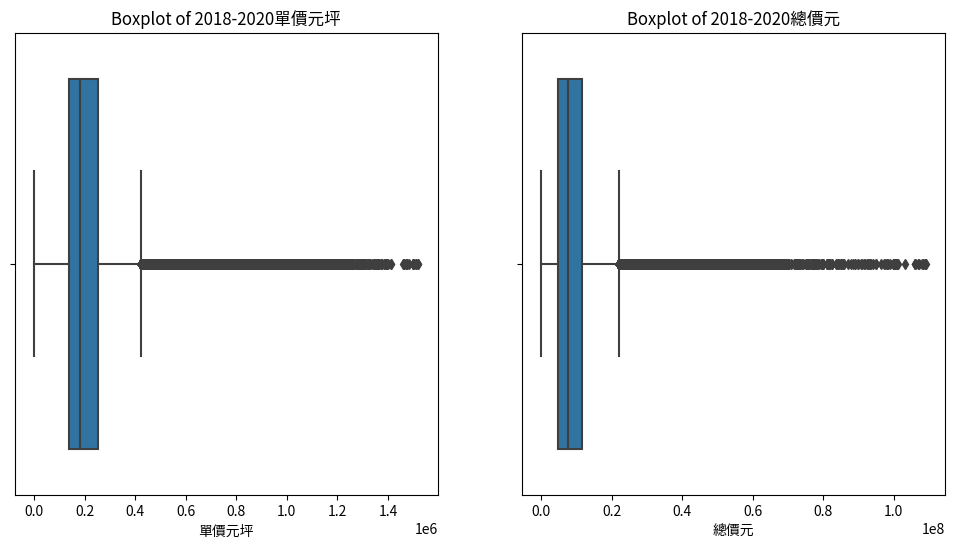

,縣市_鄉鎮市區,web單價元坪_mean_2018_2020,web單價元坪_median_2018_2020,web單價元坪_max_2018_2020,web單價元坪_min_2018_2020,web總價元_mean_2018_2020,web總價元_median_2018_2020,web總價元_max_2018_2020,web總價元_min_2018_2020
0,南投縣_中寮鄉,68916.795867,66869.52012,116820.00702,31646.32767,3069500.0,2975000.0,6000000,880000


In [1928]:
filtered_df_2018_2020 = df[(df['交易year'] < 2021) & (df['交易year'] >= 2018)]


df_no_outliers_2018_2020  = filtered_df_2018_2020.groupby('縣市_鄉鎮市區').apply(remove_outliers).reset_index(drop=True)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Create boxplots for "單價元坪" and "總價元"
sns.boxplot(x=df_no_outliers_2018_2020['單價元坪'], ax=axes[0])
sns.boxplot(x=df_no_outliers_2018_2020['總價元'], ax=axes[1])

axes[0].set_title('Boxplot of 2018-2020單價元坪')
axes[1].set_title('Boxplot of 2018-2020總價元')


plt.show()

# Group the DataFrame by '鄉鎮市區' and calculate the desired statistics
grouped_data_2018_2020 = df_no_outliers_2018_2020.groupby('縣市_鄉鎮市區')[['單價元坪', '總價元']].agg(['mean', 'median', 'max', 'min'])


grouped_data_2018_2020 = grouped_data_2018_2020.reset_index()


grouped_data_2018_2020.columns = ['縣市_鄉鎮市區', 'web單價元坪_mean_2018_2020', 'web單價元坪_median_2018_2020', 'web單價元坪_max_2018_2020', 'web單價元坪_min_2018_2020', 'web總價元_mean_2018_2020', 'web總價元_median_2018_2020', 'web總價元_max_2018_2020', 'web總價元_min_2018_2020']
grouped_data_2018_2020.head(1)



---

## Feature Generation Pipeline

In [1929]:
class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters = None, gamma = None, sample_weight = None, random_state = None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.sample_weight = sample_weight
        self.random_state = random_state

    def fit(self, X, y=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=self.sample_weight)
        return self 
    
    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [1930]:
#conbining the columns
class CombineColumnsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, source_columns, target_column, separator='_'):
        self.source_columns = source_columns
        self.target_column = target_column
        self.separator = separator
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()  
        X_copy[self.target_column] = X_copy[self.source_columns].apply(lambda row: self.separator.join(row), axis=1)
        return X_copy

In [1931]:
#This is the encoding Transofrmer 
class MapValuesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column, sets_mapping):
        self.column = column
        self.sets_mapping = sets_mapping
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()  
        X_copy[self.column] = X_copy[self.column].apply(self._map_value)
        return X_copy
    
    def _map_value(self, value):
        for set_name, set_values in self.sets_mapping.items():
            if value in set_values:
                return set_name
        return "其他"  # If no match is found, return the original value

In [1932]:
#lat and long
class CoordinateConverter(BaseEstimator, TransformerMixin):
    def __init__(self) -> None:
        super().__init__()
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        X_transformed['long'], X_transformed['lat'] = zip(*X_transformed.apply(lambda row: twd97_to_lonlat(row['橫坐標'], row['縱坐標']), axis=1))
        return X_transformed



In [1933]:
#region
class create_region(BaseEstimator, TransformerMixin):
    def __init__(self) -> None:
        super().__init__()
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        X_transformed['region'] = X_transformed.apply(lambda row: map_city_to_region(row['縣市']), axis=1)
        return X_transformed
    


In [1934]:
#總面積
class CalculateTotalArea(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy["總面積"] = X_copy["建物面積"] + X_copy["車位面積"] + X_copy["陽台面積"]
        return X_copy

#建屋面積占比
class CalculateAreaRatios(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy["建物面積占比"] = X_copy["建物面積"] / X_copy["總面積"]
        X_copy["主建物面積占比"] = X_copy["主建物面積"] / X_copy["總面積"]
        X_copy["附屬建物面積占比"] = X_copy["附屬建物面積"] / X_copy["總面積"]
        X_copy["車位面積占比"] = X_copy["車位面積"] / X_copy["總面積"]
        X_copy["陽台面積占比總面積"] = X_copy["陽台面積"] / X_copy["總面積"]
        return X_copy
    



In [1935]:
#鄉鎮市區總數及房屋佔比:總面積、車位面積、車位個數
class CalculateCountyArea(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy['鄉鎮市區房屋總面積'] = X_copy.groupby(['縣市_鄉鎮市區'])['總面積'].transform('sum')
        X_copy["鄉鎮市區車位總面積"] = X_copy.groupby(["縣市_鄉鎮市區"])['車位面積'].transform('sum')
        X_copy["鄉鎮市區車位總個數"] = X_copy.groupby(["縣市_鄉鎮市區"])["車位個數"].transform('sum')
        return X_copy

class CalculateCountyAreaRatio(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy['該房屋總面積在訓練集內所屬鄉鎮市區房屋總面積之佔比'] = X_copy["總面積"] / X_copy['鄉鎮市區房屋總面積']
        X_copy['該房屋車位面積在訓練集內所屬鄉鎮市區車位總面積之佔比'] = X_copy['車位面積'] / X_copy["鄉鎮市區車位總面積"]
        X_copy["車位個數佔比鄉鎮市區總車位數量"] = X_copy.apply(lambda row: 0 if row["鄉鎮市區車位總個數"] == 0 else row["車位個數"] / row["鄉鎮市區車位總個數"], axis=1) 
        return X_copy  




In [1936]:
#坪數
class CalculateSquareFeet(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy["房屋坪數"] = X_copy["總面積"] * 0.3025
        X_copy["土地坪數"] = X_copy["土地面積"] * 0.3025
        return X_copy




In [1937]:
#土地面積
class CalculateLandArea(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy["土地面積與建物面積之差"] = X_copy["土地面積"] - X_copy["建物面積"]
        X_copy["建物面積佔比土地面積"] = X_copy["建物面積"] / X_copy["土地面積"]
        return X_copy



In [1938]:
#鄉鎮市區均值中位數
class CalculateMeanMedianCountyArea(BaseEstimator, TransformerMixin):
    def __init__(self, groupby_column):
        self.groupby_column = groupby_column
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        grouped = X.groupby(self.groupby_column).agg({
            "土地面積": ["mean", "median"],
            "總面積": ["mean", "median"],
            "車位面積": ["mean", "median"],
            "建物面積": ["mean", "median"]
        })


        grouped.columns = [f"{col}_{agg}" for col, agg in grouped.columns]


        X_merged = X.merge(grouped, left_on=self.groupby_column, right_index=True)
        return X_merged



In [1939]:
#直轄市
class CreateDirectControlCityColumn(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        conditions = [
            X["縣市"] == "台北市",
            X["縣市"].isin(["新北市", "桃園市", "臺中市", "臺南市", "高雄市"])
        ]
        values = ["capital", "municipality"]
        X["直轄市"] = np.select(conditions, values, default="others")
        return X
    

    

In [1940]:

#樓層
class CalculateFloorRatio(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy["樓層比例"] = X_copy["移轉層次"] / X_copy["總樓層數"]
        return X_copy

class AggregateFloorRatio(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy["樓層比例_mean"] = X_copy.groupby("縣市_鄉鎮市區")["樓層比例"].transform("mean")
        X_copy["樓層比例_median"] = X_copy.groupby("縣市_鄉鎮市區")["樓層比例"].transform("median")
        return X_copy

class CalculateTotalFloors(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy["鄉鎮市區樓層總數"] = X_copy.groupby("縣市_鄉鎮市區")["總樓層數"].transform("sum")
        return X_copy

class CalculateRelativeFloorRatio(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy["移轉曾次佔比鄉鎮市區平均總樓層數"] = X_copy["移轉層次"] / X_copy.groupby("縣市_鄉鎮市區")["總樓層數"].transform("mean")
        X_copy["移轉曾次佔比鄉鎮市區中位數總樓層數"] = X_copy["移轉層次"] / X_copy.groupby("縣市_鄉鎮市區")["總樓層數"].transform("median")
        return X_copy

class IdentifyTopFloor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy['頂樓'] = ((X_copy['移轉層次'] == X_copy['總樓層數']) & (X_copy['移轉層次'] > 1)).astype(int)
        return X_copy

class CalculateTotalFloorMean(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy["鄉鎮市區總樓層數_mean"] = X_copy.groupby("縣市_鄉鎮市區")["總樓層數"].transform("mean")
        return X_copy

class CalculateTotalFloorMedian(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy["鄉鎮市區總樓層數_median"] = X_copy.groupby("縣市_鄉鎮市區")["總樓層數"].transform("median")
        return X_copy
    
#建物型態、電梯
class ExtractBuildingType(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy['建物型態2'] = X_copy['建物型態'].str.split('(').str[0]
        return X_copy

class ExtractElevatorPresence(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy['電梯'] = X_copy['建物型態'].str.contains('有電梯').astype(int)
        return X_copy

class ExtractAdditionalFeatures(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy['備註'] = X_copy['備註'].fillna('')
        X_copy['花台'] = X_copy['備註'].str.contains('花台').astype(int)
        X_copy['露臺'] = X_copy['備註'].str.contains('露臺').astype(int)
        X_copy['夾層'] = X_copy['備註'].str.contains('夾層').astype(int)
        X_copy['雨遮'] = X_copy['備註'].str.contains('雨遮').astype(int)
        X_copy['是否有其他物件'] = (X_copy['備註'].str.contains('花台') &
                                   X_copy['備註'].str.contains('露臺') &
                                   X_copy['備註'].str.contains('夾層') &
                                   X_copy['備註'].str.contains('雨遮') &
                                   X_copy['備註'].str.contains('暸望室')).astype(int)
        X_copy["備註"].replace('', np.nan, inplace=True)
        return X_copy





In [1941]:
#應用Class

class MergeData(BaseEstimator, TransformerMixin):
    def __init__(self, data_to_merge, on_column, how):
        self.data_to_merge = data_to_merge
        self.on_column = on_column
        self.how = how
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_merged = X.merge(self.data_to_merge, on=self.on_column, how=self.how)
        return X_merged

class FillMissingByCategory(BaseEstimator, TransformerMixin):
    def __init__(self, column_to_fill, grouping_column, method='mean'):
        self.column_to_fill = column_to_fill
        self.grouping_column = grouping_column
        self.method = method
    
    def fit(self, X, y=None):
        if self.method == 'mean':
            self.aggregation = X.groupby(self.grouping_column)[self.column_to_fill].mean()
        elif self.method == 'median':
            self.aggregation = X.groupby(self.grouping_column)[self.column_to_fill].median()
        else:
            raise ValueError("Invalid method. Please use 'mean' or 'median'.")
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy[self.column_to_fill].fillna(X_copy[self.grouping_column].map(self.aggregation), inplace=True)
        return X_copy
    
    def get_feature_names_out(self, names=None):
        return self.column_to_fill


class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy.drop(columns=self.columns_to_drop, inplace=True)
        return X_copy


In [1942]:
# This is the mapping of encoding based on the source of web scraping, domain knowledge, and the training set itself.
encoding_縣市_鄉鎮市區 = {
    10 : 十,
    9 : 九,
    8 : 八,
    7 : 七,
    6 : 六,
    5 : 五,
    4 : 四,
    3 : 三,
    2 : 二,
    1 : 一
}

#This is the mapping for 主要建材
material_mapping = {
    "鋼骨造": "鋼骨造",
    "其他": "其他",
    "加強磚造": "其他",
    "磚造": "其他",
    "鋼筋混凝土造": "其他",
    "鋼筋混凝土加強磚造": "鋼筋混凝土加強磚造"
}

In [1943]:
feature_generation = Pipeline([
    ('create_縣市_鄉鎮市區_路名', CombineColumnsTransformer(['縣市', '鄉鎮市區', '路名'], '縣市_鄉鎮市區_路名')),
    ('create_縣市_鄉鎮市區', CombineColumnsTransformer(['縣市', '鄉鎮市區'], '縣市_鄉鎮市區')),
    ('merge_with_web_scraping_data', MergeData(data_to_merge=grouped_data_2018_2020,on_column="縣市_鄉鎮市區",how="left")),
    ('encoding_縣市_鄉鎮市區', MapValuesTransformer('縣市_鄉鎮市區', encoding_縣市_鄉鎮市區)),
    ('grouping_主要建材', MapValuesTransformer('主要建材', material_mapping)),
    ('coordinate_converter', CoordinateConverter()),
    ('create_region', create_region()),
    ('calculate_總面積', CalculateTotalArea()),
    #('calculate_面積占比', CalculateAreaRatios()),
    #('calculate_鄉鎮市區加總', CalculateCountyArea()),
    #('calculate_房屋佔比鄉鎮市區',CalculateCountyAreaRatio()),
    #('calculate_坪數', CalculateSquareFeet()),
    #('calculate_土地面積', CalculateLandArea()),
    #('calculate_鄉鎮市區均值中位數', CalculateMeanMedianCountyArea(groupby_column = '縣市_鄉鎮市區')),
    ('create_直轄市', CreateDirectControlCityColumn()),
    #('calculate_floor_ratio', CalculateFloorRatio()),
    #('aggregate_floor_ratio', AggregateFloorRatio()),
    #('calculate_total_floors', CalculateTotalFloors()),
    #('calculate_relative_floor_ratio', CalculateRelativeFloorRatio()),
    ('identify_top_floor', IdentifyTopFloor()),
    #('calculate_total_floor_mean', CalculateTotalFloorMean()),
    #('calculate_total_floor_median', CalculateTotalFloorMedian()),
    ('extract_building_type', ExtractBuildingType()),
    ('extract_elevator_presence', ExtractElevatorPresence()),
    #('extract_additional_features', ExtractAdditionalFeatures()),
])

Use X_train_copy for the experiments

In [1944]:
X_train = train_raw.drop(columns=['單價'])
y_train = train_raw['單價'].copy()
X_train_copy = X_train.copy()
X_train_copy.head(1)

,ID,縣市,鄉鎮市區,路名,土地面積,使用分區,移轉層次,總樓層數,主要用途,主要建材,建物型態,屋齡,建物面積,車位面積,車位個數,橫坐標,縱坐標,備註,主建物面積,陽台面積,附屬建物面積,站點數,高度壞地標數,中度壞地標數,輕度壞地標數,bad_score,公園圖書館,金融機構數,學生教職員總人數,權重
0,TR-1,台北市,大安區,敦化南路二段,-0.256716,None,11,11,住家用,鋼筋混凝土造,住宅大樓(11層含以上有電梯),32.583333,-0.174154,-0.819326,0.0,305266,2768378,NaN,0.393926,0.1837,-0.438452,546.0,NaN,NaN,NaN,NaN,NaN,35.0,40566.0,11.4


In [1945]:
#Just Testing if needed
#X_train_copy_sample = X_train_copy.head(50)
#X_train_copy_sample  = feature_generation.fit_transform(X_train_copy_sample )
#X_train_copy_sample.head(1)

In [1946]:

X_train_copy  = feature_generation.fit_transform(X_train_copy)
X_train_copy.set_index(train_id_column, inplace=True)
X_train_copy.head(1)

,ID,縣市,鄉鎮市區,路名,土地面積,使用分區,移轉層次,總樓層數,主要用途,主要建材,建物型態,屋齡,建物面積,車位面積,車位個數,橫坐標,縱坐標,備註,主建物面積,陽台面積,附屬建物面積,站點數,高度壞地標數,中度壞地標數,輕度壞地標數,bad_score,公園圖書館,金融機構數,學生教職員總人數,權重,縣市_鄉鎮市區_路名,縣市_鄉鎮市區,web單價元坪_mean_2018_2020,web單價元坪_median_2018_2020,web單價元坪_max_2018_2020,web單價元坪_min_2018_2020,web總價元_mean_2018_2020,web總價元_median_2018_2020,web總價元_max_2018_2020,web總價元_min_2018_2020,long,lat,region,總面積,直轄市,頂樓,建物型態2,電梯
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TR-1,TR-1,台北市,大安區,敦化南路二段,-0.256716,None,11,11,住家用,其他,住宅大樓(11層含以上有電梯),32.583333,-0.174154,-0.819326,0.0,305266,2768378,NaN,0.393926,0.1837,-0.438452,546.0,NaN,NaN,NaN,NaN,NaN,35.0,40566.0,11.4,台北市_大安區_敦化南路二段,10,873438.842518,843247.52478,1.520435e+06,299960.77302,3.325456e+07,26590000.0,109080000,4000000,121.547608,25.022469,北部,-0.809779,capital,1,住宅大樓,1


In [1947]:
X_train_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11751 entries, TR-1 to TR-11751
Data columns (total 48 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        11751 non-null  object 
 1   縣市                        11751 non-null  object 
 2   鄉鎮市區                      11751 non-null  object 
 3   路名                        11751 non-null  object 
 4   土地面積                      11751 non-null  float64
 5   使用分區                      11751 non-null  object 
 6   移轉層次                      11751 non-null  int64  
 7   總樓層數                      11751 non-null  int64  
 8   主要用途                      11751 non-null  object 
 9   主要建材                      11751 non-null  object 
 10  建物型態                      11751 non-null  object 
 11  屋齡                        11751 non-null  float64
 12  建物面積                      11751 non-null  float64
 13  車位面積                      11751 non-null  float64
 14  車位個數 

## Feature Selection

Drop unnecessary columns if

- identification columns

- missing % >60

- only one unique value

- features that can be replaced by other columns (code vs. description)

- reference columns to other tables that are out of scope

- High correlated features
 

In [1948]:
#X_train_copy.describe().T

In [1949]:
id_col = ['鄉鎮市區', '縣市_鄉鎮市區_路名', 'ID']

print(len(id_col))

3


In [1950]:
def missing_perc(base, perc):
    desc_df = base.describe(include='all')
    missing_col = desc_df.T['count'].to_frame()
    missing_col['missing_perc'] = (len(base)- missing_col['count'])/len(base)*100
    missing_df = missing_col[missing_col['missing_perc'] >=perc]
    return missing_df

# get columns that missing % is larger than 60
missing_col = missing_perc(X_train_copy, 80)#.index
print(len(missing_col.index))
missing_col.index
missing_perc(X_train_copy, 80)

1


,count,missing_perc
備註,92,99.217088


In [1951]:
def unique_ct_1(df):
    uniq_ct_list = []
    for i in df.columns:
        uniq_ct = df[i].nunique()
        uniq_ct_list.append(uniq_ct)
    d = {'col':df.columns,'ct':uniq_ct_list}
    df = pd.DataFrame(d)
    return df[df['ct'] ==1].col.tolist()

one_uniq_col = unique_ct_1(X_train_copy)
one_uniq_col 

[]

In [1952]:
#features that can be replaced by other columns (code vs. description) and reference columns to other tables that are out of scope

ref_or_dup_col = ["建物型態"]

drop_col = id_col + missing_col.index.tolist() + one_uniq_col + ref_or_dup_col

In [1953]:
drop_col

['鄉鎮市區', '縣市_鄉鎮市區_路名', 'ID', '備註', '建物型態']

In [1954]:
X_train_copy = X_train_copy.drop(columns=drop_col, axis = 1)

In [1955]:
X_train_copy.head(1)

,縣市,路名,土地面積,使用分區,移轉層次,總樓層數,主要用途,主要建材,屋齡,建物面積,車位面積,車位個數,橫坐標,縱坐標,主建物面積,陽台面積,附屬建物面積,站點數,高度壞地標數,中度壞地標數,輕度壞地標數,bad_score,公園圖書館,金融機構數,學生教職員總人數,權重,縣市_鄉鎮市區,web單價元坪_mean_2018_2020,web單價元坪_median_2018_2020,web單價元坪_max_2018_2020,web單價元坪_min_2018_2020,web總價元_mean_2018_2020,web總價元_median_2018_2020,web總價元_max_2018_2020,web總價元_min_2018_2020,long,lat,region,總面積,直轄市,頂樓,建物型態2,電梯
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TR-1,台北市,敦化南路二段,-0.256716,None,11,11,住家用,其他,32.583333,-0.174154,-0.819326,0.0,305266,2768378,0.393926,0.1837,-0.438452,546.0,NaN,NaN,NaN,NaN,NaN,35.0,40566.0,11.4,10,873438.842518,843247.52478,1.520435e+06,299960.77302,3.325456e+07,26590000.0,109080000,4000000,121.547608,25.022469,北部,-0.809779,capital,1,住宅大樓,1


* define a function to select features that are not correlated to one another -- set threshold to 0.95

Drop features which are highly correlated with one another -- this means there are some linearly dependent with other features. These features contribute very less in predicting the output but increses the computational cost.

In [1956]:
def trimm_correlated(df_in, threshold):
    df_corr = df_in.corr(method='pearson', min_periods=1)
    print(df_corr.shape)
    df_not_correlated = ~(df_corr.mask(np.tril(np.ones([len(df_corr)]*2, dtype=bool))).abs() > threshold).any()
    un_corr_idx = df_not_correlated.loc[df_not_correlated[df_not_correlated.index] == True].index
    df_out = df_in[un_corr_idx]
    return df_out
df_corr = X_train_copy.corr(method='pearson', min_periods=1)
df_corr.head()
uncorrelated_factors = trimm_correlated(X_train_copy, 0.95)
uncorrelated_factors.shape
uncorrelated_factors.columns.tolist()
X_train_copy_num = uncorrelated_factors

(35, 35)


The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


In [1957]:
class TrimCorrelated(BaseEstimator, TransformerMixin):
    def __init__(self, threshold):
        self.threshold = threshold
    
    def fit(self, X, y=None):
        # Calculate correlation matrix
        df_corr = X.corr(method='pearson', min_periods=1)
        # Identify uncorrelated columns
        df_not_correlated = ~(df_corr.mask(np.tril(np.ones([len(df_corr)]*2, dtype=bool))).abs() > self.threshold).any()
        self.uncorrelated_columns_ = df_not_correlated[df_not_correlated.index][df_not_correlated].index.tolist()
        return self
    
    def transform(self, X):
        X_copy = X[self.uncorrelated_columns_]
        return X_copy
    def get_feature_names_out(self, names=None):
        return self.uncorrelated_columns_


In [1958]:
num_feature = X_train_copy_num.columns.tolist()
num_feature

['土地面積',
 '移轉層次',
 '總樓層數',
 '屋齡',
 '建物面積',
 '車位面積',
 '車位個數',
 '橫坐標',
 '縱坐標',
 '主建物面積',
 '陽台面積',
 '附屬建物面積',
 '站點數',
 '高度壞地標數',
 '中度壞地標數',
 '輕度壞地標數',
 'bad_score',
 '公園圖書館',
 '金融機構數',
 '學生教職員總人數',
 '縣市_鄉鎮市區',
 'web單價元坪_mean_2018_2020',
 'web單價元坪_min_2018_2020',
 'web總價元_min_2018_2020',
 '總面積',
 '頂樓',
 '電梯']

In [1959]:
cat_feature = X_train_copy.select_dtypes(include='object').columns.tolist()
cat_feature

['縣市', '路名', '使用分區', '主要用途', '主要建材', 'region', '直轄市', '建物型態2']

In [1960]:
feature_selected1 = X_train_copy[num_feature + cat_feature]

In [1961]:
#Save the very first feature selection, just internal data and web scraping data
#feature_selected1.to_csv("feature_selected1.csv")

# Modeling

## Preprocessing Pipeline

In [1962]:

#Category Features
cat = X_train_copy.select_dtypes(include='object')

num = X_train_copy.select_dtypes(np.number)

In [1963]:
cat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11751 entries, TR-1 to TR-11751
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   縣市      11751 non-null  object
 1   路名      11751 non-null  object
 2   使用分區    11751 non-null  object
 3   主要用途    11751 non-null  object
 4   主要建材    11751 non-null  object
 5   region  11751 non-null  object
 6   直轄市     11751 non-null  object
 7   建物型態2   11751 non-null  object
dtypes: object(8)
memory usage: 826.2+ KB


In [1964]:
num.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11751 entries, TR-1 to TR-11751
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   土地面積                      11751 non-null  float64
 1   移轉層次                      11751 non-null  int64  
 2   總樓層數                      11751 non-null  int64  
 3   屋齡                        11751 non-null  float64
 4   建物面積                      11751 non-null  float64
 5   車位面積                      11751 non-null  float64
 6   車位個數                      11751 non-null  float64
 7   橫坐標                       11751 non-null  int64  
 8   縱坐標                       11751 non-null  int64  
 9   主建物面積                     11751 non-null  float64
 10  陽台面積                      11751 non-null  float64
 11  附屬建物面積                    11751 non-null  float64
 12  站點數                       11240 non-null  float64
 13  高度壞地標數                    3491 non-null   float64
 14  中度壞地標

In [1965]:
X_train_copy.columns

Index(['縣市', '路名', '土地面積', '使用分區', '移轉層次', '總樓層數', '主要用途', '主要建材', '屋齡',
       '建物面積', '車位面積', '車位個數', '橫坐標', '縱坐標', '主建物面積', '陽台面積', '附屬建物面積', '站點數',
       '高度壞地標數', '中度壞地標數', '輕度壞地標數', 'bad_score', '公園圖書館', '金融機構數', '學生教職員總人數',
       '權重', '縣市_鄉鎮市區', 'web單價元坪_mean_2018_2020', 'web單價元坪_median_2018_2020',
       'web單價元坪_max_2018_2020', 'web單價元坪_min_2018_2020',
       'web總價元_mean_2018_2020', 'web總價元_median_2018_2020',
       'web總價元_max_2018_2020', 'web總價元_min_2018_2020', 'long', 'lat', 'region',
       '總面積', '直轄市', '頂樓', '建物型態2', '電梯'],
      dtype='object')

In [1966]:
cat_cols = ['縣市', '路名', '使用分區', '主要用途', '主要建材', 'region', '直轄市', '建物型態2']
num_cols = ['土地面積', '移轉層次', '總樓層數','屋齡','建物面積', '車位面積', '車位個數', '橫坐標', '縱坐標', '主建物面積', '陽台面積', '附屬建物面積', '站點數',
            'web單價元坪_mean_2018_2020', 'web單價元坪_median_2018_2020','web單價元坪_max_2018_2020', 'web單價元坪_min_2018_2020','web總價元_mean_2018_2020', 
            'web總價元_median_2018_2020','web總價元_max_2018_2020', 'web總價元_min_2018_2020', 'long', 'lat','總面積', '頂樓', '縣市_鄉鎮市區', '金融機構數', '學生教職員總人數', '權重']

bad_facilities_column = ['高度壞地標數', 
                         '中度壞地標數', 
                         '輕度壞地標數', 
                         'bad_score']
good_facilities_column = ['公園圖書館']



### cat_transformer

In [1967]:
主要建材_mapping = [['鋼筋混凝土加強磚造', '其他', '鋼骨造']]
直轄市_mapping = [['others', 'municipality','capital']]
region_mapping = [[ '東部','外島','南部', '中部','北部']]

In [1968]:
cat_transformer= make_column_transformer(
    (OrdinalEncoder(categories=主要建材_mapping), ['主要建材']),
    (OrdinalEncoder(categories=直轄市_mapping ), ['直轄市']),
    (OrdinalEncoder(categories=region_mapping ), ['region']),
    (OneHotEncoder(handle_unknown="ignore"), ['縣市']),
    (OneHotEncoder(handle_unknown="ignore"), ['路名']),
    (OneHotEncoder(handle_unknown="ignore"), ['主要用途']),
    (OneHotEncoder(handle_unknown="ignore"), ['建物型態2']),
)



### Missing Value Imputer

In [1969]:
#bus_station_imputer 
bus_station_imputer = FillMissingByCategory(column_to_fill="站點數", grouping_column="縣市_鄉鎮市區", method= 'median')

# bad_facilities_imputer
bad_facilities_imputer = SimpleImputer(strategy = "constant" , fill_value = 0)
bad_facilities_column

# good_facilities_imputer
good_facilities_imputer = SimpleImputer(strategy = "constant" , fill_value = 0)
good_facilities_column

# finance_imputer
finance_imputer= FillMissingByCategory(column_to_fill="金融機構數", grouping_column="縣市_鄉鎮市區", method= 'median')

#elementry_imputer
elementry_imputer_學生教職員總人數 = FillMissingByCategory(column_to_fill="學生教職員總人數", grouping_column="縣市_鄉鎮市區", method= 'median')
elementry_imputer_權重 = FillMissingByCategory(column_to_fill="權重", grouping_column="縣市_鄉鎮市區", method= 'median')

### num_transforme

* 將skew>0.8的feature做log transformation

In [1970]:
#還沒用，Code有問題
#from scipy.stats import skew
#skewness = num_cols.apply(lambda x: skew(x))
#high_skew_cols = skewness[skewness > 0.8].index

#from sklearn.preprocessing import FunctionTransformer
#def log_transform(x):
    #print(x)
    #return np.log(x + 1)
#log_transformer = FunctionTransformer(log_transform)

#high_skew_cols

In [1971]:
num_transformer = Pipeline([ 
     ('bus_station_imputer', bus_station_imputer),
     ('finance_imputer', finance_imputer),
     ('elementry_imputer_學生教職員總人數', elementry_imputer_學生教職員總人數),
     ('elementry_imputer_權重', elementry_imputer_權重),
     ('trim_hogh_corr', TrimCorrelated(0.95)),
                            
    #('standardization', StandardScaler()),
    #('log_transform', log_transformer)
])

In [1972]:

preprocessing = ColumnTransformer(
    transformers=[
        ("categorical", cat_transformer, cat_cols),
        ("geo", ClusterSimilarity(n_clusters=10, gamma=1., random_state=42), ["lat", "long"]), #This is another feature generation
        ("bad_facilities_imputer", bad_facilities_imputer, bad_facilities_column),
        ('good_facilities_imputer', good_facilities_imputer, good_facilities_column),
        ("numeric", num_transformer, num_cols),
    ],
      remainder="passthrough")  
preprocessing

ColumnTransformer(remainder='passthrough',
                  transformers=[('categorical',
                                 ColumnTransformer(transformers=[('ordinalencoder-1',
                                                                  OrdinalEncoder(categories=[['鋼筋混凝土加強磚造',
                                                                                              '其他',
                                                                                              '鋼骨造']]),
                                                                  ['主要建材']),
                                                                 ('ordinalencoder-2',
                                                                  OrdinalEncoder(categories=[['others',
                                                                                              'municipality',
                                                                                              'capital']]),
                                                                  ['直轄市']),
                                                                 ('ordinalencoder-3',
                                                                  OrdinalEncoder(categories=[['東部',
                                                                                              '外島',
                                                                                              '南部',
                                                                                              '中部',
                                                                                              '...
                                                  TrimCorrelated(threshold=0.95))]),
                                 ['土地面積', '移轉層次', '總樓層數', '屋齡', '建物面積', '車位面積',
                                  '車位個數', '橫坐標', '縱坐標', '主建物面積', '陽台面積',
                                  '附屬建物面積', '站點數', 'web單價元坪_mean_2018_2020',
                                  'web單價元坪_median_2018_2020',
                                  'web單價元坪_max_2018_2020',
                                  'web單價元坪_min_2018_2020',
                                  'web總價元_mean_2018_2020',
                                  'web總價元_median_2018_2020',
                                  'web總價元_max_2018_2020',
                                  'web總價元_min_2018_2020', 'long', 'lat', '總面積',
                                  '頂樓', '縣市_鄉鎮市區', '金融機構數', '學生教職員總人數',
                                  '權重'])])

In [1973]:
#preprocessed = preprocessing.fit_transform(X_train_copy)
#preprocessed.shape

In [1974]:
X_train_copy

,縣市,路名,土地面積,使用分區,移轉層次,總樓層數,主要用途,主要建材,屋齡,建物面積,車位面積,車位個數,橫坐標,縱坐標,主建物面積,陽台面積,附屬建物面積,站點數,高度壞地標數,中度壞地標數,輕度壞地標數,bad_score,公園圖書館,金融機構數,學生教職員總人數,權重,縣市_鄉鎮市區,web單價元坪_mean_2018_2020,web單價元坪_median_2018_2020,web單價元坪_max_2018_2020,web單價元坪_min_2018_2020,web總價元_mean_2018_2020,web總價元_median_2018_2020,web總價元_max_2018_2020,web總價元_min_2018_2020,long,lat,region,總面積,直轄市,頂樓,建物型態2,電梯
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TR-1,台北市,敦化南路二段,-0.256716,None,11,11,住家用,其他,32.583333,-0.174154,-0.819326,0.0,305266,2768378,0.393926,0.183700,-0.438452,546.0,NaN,NaN,NaN,NaN,NaN,35.0,40566.0,11.40,10,873438.842518,843247.524780,1.520435e+06,299960.77302,3.325456e+07,26590000.0,109080000,4000000,121.547608,25.022469,北部,-0.809779,capital,1,住宅大樓,1
TR-2,台北市,水源路,0.100134,None,7,12,住家用,其他,24.166667,0.314204,-0.819326,0.0,300677,2767990,-0.316131,0.608577,-0.438452,244.0,NaN,NaN,NaN,NaN,NaN,4.0,20359.0,6.35,9,529551.189519,527518.133460,9.158526e+05,152720.88642,1.898667e+07,16100000.0,56100000,510000,121.502124,25.019127,北部,0.103455,capital,0,住宅大樓,1
TR-3,高雄市,北忠街,0.181921,None,10,15,集合住宅,其他,6.166667,0.423366,0.161624,1.0,184815,2504666,-0.098871,-0.360620,1.525881,74.0,0.0,0.0,1.0,1.1,1.0,2.0,13359.0,4.50,5,159582.786483,161130.816180,3.020533e+05,41560.39188,6.276418e+06,5780000.0,15700000,200000,120.365799,22.640966,南部,0.224370,municipality,0,住宅大樓,1
TR-4,新北市,福前街,0.085594,None,9,14,集合住宅,其他,8.833333,0.164249,0.524653,1.0,296653,2772355,-0.071147,0.315088,0.231984,209.0,NaN,NaN,NaN,NaN,3.0,15.0,32882.0,8.80,8,372336.120189,376982.374230,6.344208e+05,113735.70495,1.480026e+07,13000000.0,37060000,500000,121.462402,25.058663,北部,1.003990,municipality,0,住宅大樓,1
TR-5,新北市,文化路一段,-0.938116,None,41,43,住家用,鋼骨造,11.000000,0.985839,0.532377,1.0,297377,2768472,0.791954,1.719400,-0.438452,357.0,0.0,0.0,2.0,2.2,6.0,30.0,27524.0,6.70,8,440518.414692,427617.159660,7.976706e+05,95104.27251,1.447010e+07,13700000.0,33750000,1080000,121.469444,25.023585,北部,3.237616,municipality,0,住宅大樓,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TR-11747,桃園市,介壽路二段,0.706189,其他,4,5,住家用,其他,28.333333,-0.271825,0.484488,1.0,280165,2758675,0.146962,-0.181455,-0.171559,133.0,NaN,NaN,NaN,NaN,4.0,2.0,5174.0,1.60,5,174782.226302,176558.938110,2.729624e+05,84320.78553,7.602524e+06,7300000.0,16120000,600000,121.298684,24.935576,北部,0.031208,municipality,0,公寓,0
TR-11748,新竹市,東南街,-0.225809,None,2,7,住家用,其他,29.250000,-0.325832,-0.819326,0.0,247333,2743084,-0.181192,-0.067131,-0.163018,138.0,0.0,0.0,1.0,1.1,2.0,9.0,19964.0,6.05,6,208458.228169,203727.573225,4.079808e+05,38618.23878,9.804254e+06,8500000.0,28300000,360000,120.973622,24.795109,北部,-1.212289,others,0,華廈,1
TR-11749,新北市,建成路,-0.943908,None,15,17,住家用,其他,22.833333,-0.848662,-0.819326,0.0,316680,2773938,-0.901999,-0.495421,-0.171559,379.0,NaN,NaN,NaN,NaN,4.0,6.0,7362.0,2.30,8,306172.202706,316116.168750,5.333000e+05,75041.43300,1.111952e+07,10350000.0,27800000,500000,121.660968,25.072204,北部,-2.163408,municipality,0,住宅大樓,1


## Full Pipeline

In [1975]:
pipeline_test = Pipeline([
    ('feature_generation', feature_generation), 
    ('drop_columns', DropColumns(columns_to_drop=drop_col)),
    ('preprocessing', preprocessing),
    #("selectioon", SelectFromModel(RandomForestRegressor(), threshold='median')),
    ("rf2", RandomForestRegressor(random_state=42)),
])

將目標變數轉為常態分佈

In [1976]:

from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(output_distribution="normal")

pipeline_test = TransformedTargetRegressor(regressor=pipeline_test, transformer=qt)

In [1977]:
pipeline_test.fit(X_train, y_train)


The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


TransformedTargetRegressor(regressor=Pipeline(steps=[('feature_generation',
                                                      Pipeline(steps=[('create_縣市_鄉鎮市區_路名',
                                                                       CombineColumnsTransformer(source_columns=['縣市',
                                                                                                                 '鄉鎮市區',
                                                                                                                 '路名'],
                                                                                                 target_column='縣市_鄉鎮市區_路名')),
                                                                      ('create_縣市_鄉鎮市區',
                                                                       CombineColumnsTransformer(source_columns=['縣市',
                                                                                                                 '鄉鎮市區'],
                                                                                                 target_column='縣市_鄉鎮市區')),
                                                                      ('merge_with_web_scraping_data',
                                                                       MergeData(data_to_...
                                                                                        'web單價元坪_mean_2018_2020',
                                                                                        'web單價元坪_median_2018_2020',
                                                                                        'web單價元坪_max_2018_2020',
                                                                                        'web單價元坪_min_2018_2020',
                                                                                        'web總價元_mean_2018_2020',
                                                                                        'web總價元_median_2018_2020',
                                                                                        'web總價元_max_2018_2020',
                                                                                        'web總價元_min_2018_2020',
                                                                                        'long',
                                                                                        'lat',
                                                                                        '總面積',
                                                                                        '頂樓',
                                                                                        '縣市_鄉鎮市區',
                                                                                        '金融機構數',
                                                                                        '學生教職員總人數',
                                                                                        '權重'])])),
                                                     ('rf2',
                                                      RandomForestRegressor(random_state=42))]),
                           transformer=QuantileTransformer(output_distribution='normal'))

In [1978]:
#如果要執行這邊的feature importance就先不要用上面的TransformedTargetRegressor

feature_importance = pipeline_test.named_steps['rf2'].feature_importances_
importance = sorted(zip(feature_importance, pipeline_test["preprocessing"].get_feature_names_out()),
                    reverse= True)
pd.DataFrame(importance, columns=['importance', 'variables']).head(50)

AttributeError: 'TransformedTargetRegressor' object has no attribute 'named_steps'

In [1846]:
cross_val_score(pipeline_test, X_train, y_train, scoring=nmape_scorer, cv=3)


The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


array([-8.19265762, -8.11147383, -8.51019753])

baseline: [-8.88523807, -8.65968205, -9.1134326 ]

all : [-46.3991155 , -46.19105728, -48.97696574]

no_encode_鄉鎮市區 : [-8.90566588, -8.69444821, -9.18188255]

encoded_鄉鎮市區: [-8.90200713, -8.55231781, -9.16975367]

add_路名: [-8.7563139 , -8.5281287 , -9.04556365]

no_土地面積: [-8.73099137, -8.49226096, -8.99977706]

no_calculate_floor_ratio = [-8.74258074, -8.46505833, -8.98125914]

no_alculate_面積占比 = [-8.36652292, -8.23016444, -8.64995124]

add_bus_station = [-8.27881664, -8.20034675, -8.60852826]

add_bus_station_ma_經緯轉法 = [-8.27873935, -8.21264953, -8.61444855] 

add_bad_score = [-8.30679211, -8.20490303, -8.60030672]

add_bad_good_landmark = [-8.27501063, -8.2031637 , -8.61224175] **best so far**

add_elementry_finance = [-8.19265762, -8.11147383, -8.51019753]

In [ ]:
baseline = [-8.88523807, -8.65968205, -9.1134326 ]
statistics.mean(baseline)


-8.886117573333333

In [1979]:
import statistics

all = [-46.3991155, -46.19105728, -48.97696574]
statistics.mean(all)

no_encode_鄉鎮市區 = [-8.90566588, -8.69444821, -9.18188255]
statistics.mean(no_encode_鄉鎮市區)

encoded_鄉鎮市區 = [-8.90200713, -8.55231781, -9.16975367]
statistics.mean(encoded_鄉鎮市區)

add_路名= [-8.7563139 , -8.5281287 , -9.04556365]
statistics.mean(add_路名)

no_土地面積= [-8.73099137, -8.49226096, -8.99977706]
statistics.mean(no_土地面積)

no_calculate_floor_ratio = [-8.74258074, -8.46505833, -8.98125914]
statistics.mean(no_calculate_floor_ratio)

no_calculate_面積占比 = [-8.36652292, -8.23016444, -8.64995124]
statistics.mean(no_calculate_面積占比)

add_bus_station = [-8.27881664, -8.20034675, -8.60852826]
statistics.mean(add_bus_station)

add_bus_station_ma_經緯轉法 = [-8.27873935, -8.21264953, -8.61444855]
statistics.mean(add_bus_station_ma_經緯轉法)

add_bad_score = [-8.30679211, -8.20490303, -8.60030672]
statistics.mean(add_bad_score)

add_bad_good_landmark = [-8.27501063, -8.2031637 , -8.61224175]
statistics.mean(add_bad_good_landmark)

add_elementry_finance = [-8.19265762, -8.11147383, -8.51019753]
statistics.mean(add_elementry_finance)

-8.271442993333332

In [1980]:
pred_add_elementry_finance = pipeline_test.predict(test)
pred_add_elementry_finance  = pd.DataFrame({'ID': test_id_column, 'predicted_price': pred_add_elementry_finance})

In [1981]:
pred_add_elementry_finance

,ID,predicted_price
0,PU-1,1.699877
1,PU-2,1.676454
2,PU-3,2.746858
3,PU-4,1.418804
4,PU-5,3.550270
...,...,...
5871,PU-5872,1.582763
5872,PU-5873,1.582763
5873,PU-5874,1.981757
5874,PU-5875,2.888620


In [1982]:
pred_add_elementry_finance.to_csv("prediction/pred_add_elementry_finance.csv", index=False)

---

---

## 小結

* 目前最佳feature:  

    * num: 
土地面積',
 '移轉層次',
 '總樓層數',
 '屋齡',
 '建物面積',
 '車位面積',
 '車位個數',
 '橫坐標',
 '縱坐標',
 '主建物面積',
 '陽台面積',
 '附屬建物面積',
 '縣市_鄉鎮市區',
 'web單價元坪_mean_2018_2020',
 'web單價元坪_min_2018_2020',
 'web總價元_min_2018_2020',
 '總面積',
 '頂樓',
 '電梯',
 '站點數',
 '地理位置cluster",
 '高度壞地標數', 
 '中度壞地標數', 
 '輕度壞地標數', 
 'bad_score',
 '公園圖書館',
 '金融機構數',	
 '學生教職員總人數',
 '權重'
 

    * cat: 
    '縣市', '路名', '使用分區', '主要用途', '主要建材', 'region', '直轄市', '建物型態2'

In [1540]:
import shap

In [1692]:
data_best_feature = pd.merge(cat, X_train_copy_num, on='ID')

In [1693]:
data_best_feature

,縣市,路名,使用分區,主要用途,主要建材,region,直轄市,建物型態2,土地面積,移轉層次,總樓層數,屋齡,建物面積,車位面積,車位個數,橫坐標,縱坐標,主建物面積,陽台面積,附屬建物面積,站點數,高度壞地標數,中度壞地標數,輕度壞地標數,bad_score,公園圖書館,縣市_鄉鎮市區,web單價元坪_mean_2018_2020,web單價元坪_min_2018_2020,web總價元_min_2018_2020,總面積,頂樓,電梯
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TR-1,台北市,敦化南路二段,None,住家用,其他,北部,capital,住宅大樓,-0.256716,11,11,32.583333,-0.174154,-0.819326,0.0,305266,2768378,0.393926,0.183700,-0.438452,546.0,NaN,NaN,NaN,NaN,NaN,10,873438.842518,299960.77302,4000000,-0.809779,1,1
TR-2,台北市,水源路,None,住家用,其他,北部,capital,住宅大樓,0.100134,7,12,24.166667,0.314204,-0.819326,0.0,300677,2767990,-0.316131,0.608577,-0.438452,244.0,NaN,NaN,NaN,NaN,NaN,9,529551.189519,152720.88642,510000,0.103455,0,1
TR-3,高雄市,北忠街,None,集合住宅,其他,南部,municipality,住宅大樓,0.181921,10,15,6.166667,0.423366,0.161624,1.0,184815,2504666,-0.098871,-0.360620,1.525881,74.0,0.0,0.0,1.0,1.1,1.0,5,159582.786483,41560.39188,200000,0.224370,0,1
TR-4,新北市,福前街,None,集合住宅,其他,北部,municipality,住宅大樓,0.085594,9,14,8.833333,0.164249,0.524653,1.0,296653,2772355,-0.071147,0.315088,0.231984,209.0,NaN,NaN,NaN,NaN,3.0,8,372336.120189,113735.70495,500000,1.003990,0,1
TR-5,新北市,文化路一段,None,住家用,鋼骨造,北部,municipality,住宅大樓,-0.938116,41,43,11.000000,0.985839,0.532377,1.0,297377,2768472,0.791954,1.719400,-0.438452,357.0,0.0,0.0,2.0,2.2,6.0,8,440518.414692,95104.27251,1080000,3.237616,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TR-11747,桃園市,介壽路二段,其他,住家用,其他,北部,municipality,公寓,0.706189,4,5,28.333333,-0.271825,0.484488,1.0,280165,2758675,0.146962,-0.181455,-0.171559,133.0,NaN,NaN,NaN,NaN,4.0,5,174782.226302,84320.78553,600000,0.031208,0,0
TR-11748,新竹市,東南街,None,住家用,其他,北部,others,華廈,-0.225809,2,7,29.250000,-0.325832,-0.819326,0.0,247333,2743084,-0.181192,-0.067131,-0.163018,138.0,0.0,0.0,1.0,1.1,2.0,6,208458.228169,38618.23878,360000,-1.212289,0,1
TR-11749,新北市,建成路,None,住家用,其他,北部,municipality,住宅大樓,-0.943908,15,17,22.833333,-0.848662,-0.819326,0.0,316680,2773938,-0.901999,-0.495421,-0.171559,379.0,NaN,NaN,NaN,NaN,4.0,8,306172.202706,75041.43300,500000,-2.163408,0,1
